In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Supervised Subject Adversarial 

The aging-related contraction of motor repertoire is a multivariate nonlinear phenomenon that cannot be captured by univariate dynamical metrics alone

In [1]:
# Imports 
# -------------------------
import os, random, sys, time, json
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import zarr 
from torch.optim.lr_scheduler import ReduceLROnPlateau


SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# -------------------------
# Device selection (CUDA > MPS > CPU)
# -------------------------
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = pick_device()
print("Using device:", device)

# -------------------------
# Import your pipeline
# -------------------------
os.chdir('..')
sys.path.insert(0, os.getcwd())

from AE_pipeline_pytorch import (
    MultiSubjectGaitBatchIterable,
    MultiSubjectGaitBatchIterable2,
    GaitBatchIterable,
    SemiSupAE,
    EMATeacher,
    train_step,
)

Using device: mps
Using device: cpu


In [2]:
#Count unique subjects in train/val/test splits using the JSON files
G01_TRAIN="Data_Split/G01_train_subjects.json"
G01_VAL="Data_Split/G01_validation_subjects.json"
G01_TEST="Data_Split/G01_test_subjects.json"
G02_TRAIN="Data_Split/G02_train_subjects.json"
G02_VAL="Data_Split/G02_validation_subjects.json"
G02_TEST="Data_Split/G02_test_subjects.json"   
G03_TRAIN="Data_Split/G03_train_subjects.json"
G03_VAL="Data_Split/G03_validation_subjects.json"
G03_TEST="Data_Split/G03_test_subjects.json"
with open(G01_TRAIN, "r") as f:
    G01_train_subjects = json.load(f)
with open(G01_VAL, "r") as f:
    G01_val_subjects = json.load(f)
with open(G01_TEST, "r") as f:
    G01_test_subjects = json.load(f)    
with open(G02_TRAIN, "r") as f:
    G02_train_subjects = json.load(f)
with open(G02_VAL, "r") as f:       
    G02_val_subjects = json.load(f)
with open(G02_TEST, "r") as f:
    G02_test_subjects = json.load(f)
with open(G03_TRAIN, "r") as f:
    G03_train_subjects = json.load(f)
with open(G03_VAL, "r") as f:
    G03_val_subjects = json.load(f)
with open(G03_TEST, "r") as f:
    G03_test_subjects = json.load(f)    
print("# subjects - G01: train", len(G01_train_subjects), "val", len(G01_val_subjects), "test", len(G01_test_subjects))
print("# subjects - G02: train", len(G02_train_subjects), "val", len(G02_val_subjects), "test", len(G02_test_subjects))
print("# subjects - G03: train", len(G03_train_subjects), "val", len(G03_val_subjects), "test", len(G03_test_subjects))    
print("Total unique subjects - Train:",
      len(set(G01_train_subjects.keys())
          | set(G02_train_subjects.keys())
          | set(G03_train_subjects.keys())),
      "Val:",
      len(set(G01_val_subjects.keys())
          | set(G02_val_subjects.keys())
          | set(G03_val_subjects.keys())),
      "Test:",
      len(set(G01_test_subjects.keys())
          | set(G02_test_subjects.keys())
          | set(G03_test_subjects.keys())))

# subjects - G01: train 26 val 5 test 4
# subjects - G02: train 36 val 7 test 7
# subjects - G03: train 28 val 6 test 6
Total unique subjects - Train: 90 Val: 18 Test: 17


In [3]:
# count cycles per set 
import json

paths = {
    "G01": {
        "train": "Data_Split/G01_train_subjects.json",
        "val":   "Data_Split/G01_validation_subjects.json",
        "test":  "Data_Split/G01_test_subjects.json",
    },
    "G02": {
        "train": "Data_Split/G02_train_subjects.json",
        "val":   "Data_Split/G02_validation_subjects.json",
        "test":  "Data_Split/G02_test_subjects.json",
    },
    "G03": {
        "train": "Data_Split/G03_train_subjects.json",
        "val":   "Data_Split/G03_validation_subjects.json",
        "test":  "Data_Split/G03_test_subjects.json",
    },
}

def load(p):
    with open(p, "r") as f:
        return json.load(f)

def n_subjects(d): return len(d)
def n_cycles(d):   return sum(d.values())

data = {g: {s: load(p) for s, p in splits.items()} for g, splits in paths.items()}

# Por grupo
for g in ["G01", "G02", "G03"]:
    tr, va, te = data[g]["train"], data[g]["val"], data[g]["test"]
    print(f"{g} #subjects - train {n_subjects(tr)} val {n_subjects(va)} test {n_subjects(te)}")
    print(f"{g} #cycles   - train {n_cycles(tr)} val {n_cycles(va)} test {n_cycles(te)}\n")

# Totales (G01+G02+G03) por split
train_all = {**data["G01"]["train"], **data["G02"]["train"], **data["G03"]["train"]}
val_all   = {**data["G01"]["val"],   **data["G02"]["val"],   **data["G03"]["val"]}
test_all  = {**data["G01"]["test"],  **data["G02"]["test"],  **data["G03"]["test"]}

print("Total unique subjects - Train:", n_subjects(train_all), "Val:", n_subjects(val_all), "Test:", n_subjects(test_all))
print("Total cycles          - Train:", n_cycles(train_all), "Val:", n_cycles(val_all), "Test:", n_cycles(test_all))

G01 #subjects - train 26 val 5 test 4
G01 #cycles   - train 88448 val 19040 test 14980

G02 #subjects - train 36 val 7 test 7
G02 #cycles   - train 133348 val 27579 test 26027

G03 #subjects - train 28 val 6 test 6
G03 #cycles   - train 106326 val 23277 test 20135

Total unique subjects - Train: 90 Val: 18 Test: 17
Total cycles          - Train: 328122 Val: 69896 Test: 61142


In [ ]:
# Inspección rápida del formato de los datos en el zarr
z = zarr.open("train_cycles.zarr", mode="r")

print("Arrays disponibles:", list(z.array_keys()))
print("Groups disponibles:", list(z.group_keys()))

data = z["data"]   # o el nombre correcto si no es "data"
print("Shape total:", data.shape)

# Tomar un ejemplo
sample = data[0]  # (100, 343)
print("Shape sample:", sample.shape)

total_dim = sample.shape[1]
print("Total dim:", total_dim)

meta_dim = 7
feat_dim = total_dim - meta_dim

print("Inferido feat_dim:", feat_dim)
print("Inferido meta_dim:", meta_dim)

# Separar
X = sample[:, :feat_dim]
M = sample[:, feat_dim:]

print("X shape:", X.shape)
print("Meta shape:", M.shape)

# Ver contenido meta para confirmar que realmente es meta
print("Meta first row:", M[0])

Arrays disponibles: ['data']
Groups disponibles: []
Shape total: (326115, 100, 343)
Shape sample: (100, 343)
Total dim: 343
Inferido feat_dim: 336
Inferido meta_dim: 7
X shape: (100, 336)
Meta shape: (100, 7)
Meta first row: [1. 1. 1. 1. 1. 1. 0.]


In [2]:
# DataLoader 
# -------------------------
train_path = "train_cycles.zarr"
val_path   = "val_cycles.zarr"
test_path  = "test_cycles.zarr"

train_slices_json = "train_subject_slices.json"
val_slices_json   = "val_subject_slices.json"
test_slices_json  = "test_subject_slices.json"

train_td_json = "train_trial_day_slices.json"
val_td_json   = "val_trial_day_slices.json"
test_td_json  = "test_trial_day_slices.json"

patients_per_batch  = 36
patients_per_batch_val  = 9
patients_per_batch_test  = 17
samples_per_patient = 8

num_workers = 0   # Mac/MPS más estable con 0

train_ds = MultiSubjectGaitBatchIterable2(
        store_path=train_path,
        subject_slices_json=train_slices_json,
        trial_slices_json=None,
        trial_day_slices_json=train_td_json,
        no_replace_within_subject=True,
        day_balanced=True,
        use_bin_sampling=True,
        sort_indices_for_io=True,
        patients_per_batch=patients_per_batch,
        samples_per_patient=samples_per_patient,
        return_meta=True,
        shuffle_subjects=True,
        seed=SEED,
        feat_dim=336,
        t_steps=100,
        meta_dim=7,
        infinite=True,              # útil para entrenamiento por épocas sin preocuparse del final
        require_full_batch=True,     # asegura batches completos de pacientes+ejemplos
    )


train_loader = DataLoader(
    train_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,              # MPS: False
    persistent_workers=False,
)

val_ds = MultiSubjectGaitBatchIterable2(
        store_path=val_path,
        subject_slices_json=val_slices_json,
        trial_slices_json=None,
        trial_day_slices_json=val_td_json,
        no_replace_within_subject=True,
        day_balanced=True,
        use_bin_sampling=True,
        sort_indices_for_io=True,
        patients_per_batch=patients_per_batch_val,
        samples_per_patient=samples_per_patient,
        return_meta=True,
        shuffle_subjects=False,   
        seed=42,
        feat_dim=336,
        t_steps=100,
        meta_dim=7,
        infinite=False,
        require_full_batch=False,
    )

val_loader = DataLoader(
    val_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,
)


test_ds = MultiSubjectGaitBatchIterable2(
        store_path=test_path,
        subject_slices_json=test_slices_json,
        trial_slices_json=None,
        trial_day_slices_json=test_td_json,
        no_replace_within_subject=True,
        day_balanced=True,
        use_bin_sampling=True,
        sort_indices_for_io=True,
        patients_per_batch=patients_per_batch_test,
        samples_per_patient=samples_per_patient,
        return_meta=True,
        shuffle_subjects=False,   
        seed=42,
        feat_dim=336,
        t_steps=100,
        meta_dim=7,
        infinite=False,
        require_full_batch=False,
    )

test_loader = DataLoader(
    test_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,
)

x, meta0, cycle_id = next(iter(val_loader))
print(x.shape, meta0.shape, cycle_id.shape)
print("unique subj:", meta0[:,0].unique())
print("unique day :", meta0[:,2].unique())
print("unique trial:", meta0[:,4].unique())

torch.Size([72, 100, 336]) torch.Size([72, 7]) torch.Size([72])
unique subj: tensor([ 0.,  4.,  5.,  9., 19., 26., 28., 43., 47.])
unique day : tensor([0., 1., 2.])
unique trial: tensor([0., 1., 2., 3.])


In [10]:
# IGNORE check test 
z = zarr.open("train_cycles.zarr", mode="r")["data"]

print("Shape:", z.shape)
print("Dtype:", z.dtype)
print("Chunks:", z.chunks)

Shape: (326115, 100, 343)
Dtype: float32
Chunks: (2048, 100, 343)


In [ ]:
# IGNORE check test 
with open("train_subject_slices.json") as f:
    subj_slices = json.load(f)

# pick first subject
sid_str, (lo, hi) = list(subj_slices.items())[0]
sid = int(sid_str)

print("Testing subject:", sid)
print("Slice range:", lo, hi)

# check that all cycles in slice have same sid in metadata
sid_col = 336  # meta starts at col 336, subject_col_in_meta=0

meta_sids = z[lo:hi, 0, sid_col]
print("Unique sids inside slice:", np.unique(meta_sids))



Testing subject: 1
Slice range: 0 3501
Unique sids inside slice: [1.]
Unique sids inside slice: [1.] ...


In [15]:
# IGNORE check test 
with open("train_trial_slices.json") as f:
    trial_slices = json.load(f)

# pick one subject
sid_str = list(trial_slices.keys())[0]
trials_dict = trial_slices[sid_str]

print("Testing subject:", sid_str)
print("Trials found:", trials_dict.keys())

trial_col = 336 + 4  # trial_col_in_meta=4

for trial_str, (lo, hi) in trials_dict.items():
    meta_trials = z[lo:hi, 0, trial_col]
    unique_trials = np.unique(meta_trials)
    print(f"Trial {trial_str} slice unique values:", unique_trials)

Testing subject: 1
Trials found: dict_keys(['1', '2', '3'])
Trial 1 slice unique values: [1.]
Trial 2 slice unique values: [2.]
Trial 3 slice unique values: [3.]


In [16]:
# IGNORE check test 
for sid_str, trials_dict in list(trial_slices.items())[:5]:
    all_ranges = []
    for lo, hi in trials_dict.values():
        all_ranges.append((lo, hi))
    print(sid_str, "trial blocks:", all_ranges)

1 trial blocks: [(0, 1165), (1165, 2329), (2329, 3501)]
3 trial blocks: [(3501, 4769), (4769, 6043), (6043, 7318)]
6 trial blocks: [(7318, 8506), (8506, 9696), (9696, 10886)]
7 trial blocks: [(10886, 12034), (12034, 13178), (13178, 14320)]
10 trial blocks: [(14320, 15604), (15604, 16887), (16887, 18137)]


In [3]:
# Mapeo de sujetos a índices para Adversarial Training
train_subjects = train_loader.dataset.subjects
val_subjects = val_loader.dataset.subjects
test_subjects = test_loader.dataset.subjects
all_unique_subjects = sorted(list(set(train_subjects) | set(val_subjects) | set(test_subjects)))

# Creamos el diccionario "Traductor"
subject_to_idx = {sid: i for i, sid in enumerate(all_unique_subjects)}
n_subjects_total = len(all_unique_subjects)

print(f"Total sujetos únicos: {n_subjects_total}") 

Total sujetos únicos: 126


In [4]:
# Meta indexes 
META_SUBJECT = 0
META_GROUP   = 1
META_DAY     = 2

def pack_batch(x, meta0, subject_mapper):
    # META_SUBJECT = 0 | META_GROUP = 1 | META_DAY = 2
    
    # 1. TRADUCCIÓN DE IDs (Evita que el ID 186 rompa el modelo)
    raw_pids = meta0[:, 0].long().tolist()
    mapped_pids = torch.tensor([subject_mapper[sid] for sid in raw_pids])
    
    # 2. AJUSTE DE GRUPO (Pasa 1,2,3 a 0,1,2 para que el Grupo 3 sea visible)
    y_group = (meta0[:, 1].long() - 1)

    # 3. DÍA (0 o 1)
    day_raw = meta0[:, 2].long()
    day = (meta0[:, 2].long() - 1).clamp(min=0)   # D01->0, D02->1

    return {
        "x": x.to(device),
        "y_group": y_group.to(device),
        "patient_id": mapped_pids.to(device),
        "nuis": day.to(device)
    }


In [5]:
# Configuración del modelo y entrenamiento
n_group = 3
n_nuisance = 2  # Day 1 vs Day 2
n_subjects = n_subjects_total

model = SemiSupAE(
    steps=100,
    in_dim=336,
    latent=16,
    n_group=n_group,
    n_subjects=n_subjects,
    n_nuisance=n_nuisance
).to(device)

teacher = EMATeacher(model, ema=0.995)



optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Pesos científicos recomendados
weights = dict(
    rec=0.2,
    group=1.0,
    supcon=0.0,   # <- APAGADO (evita identidad)
    cons=0.0,
    adv=0.0,      # <- fuerza invariancia a Day
    subj_adv=0.1,      # <- fuerza invariancia a subject_iD
    pseudo_w=0.0
)

pseudo_thresh = 0.95
steps_per_epoch = 60 # 328122/288=1139 
val_steps = 20 # 400/288=1.38 -> solo 2 batches de validación para evaluación rápida durante el desarrollo


In [21]:
# Funciones de entrenamiento y evaluación por época
class GaitAugmentor:
    """
    Strong-but-safe augmentations for kinematic time series x:[B,T,C].
    - jitter: Gaussian noise
    - scaling: per-channel random gain
    - channel dropout: randomly zero some channels (simulates sensor dropout)
    """
    def __init__(self, sigma=0.015, scale_range=(0.95, 1.05), ch_dropout_prob=0.02):
        self.sigma = sigma
        self.scale_range = scale_range
        self.ch_dropout_prob = ch_dropout_prob

    @torch.no_grad()
    def apply(self, x):
        """
        x: [Batch, Steps, Channels]
        """
        device = x.device
        x_aug = x.clone()
        
        # 1. Jitter (Ruido Gaussiano)
        x_aug += torch.randn_like(x_aug) * self.sigma
        
        # 2. Scaling (Escalado aleatorio por canal)
        # Genera un factor para cada canal de forma independiente
        scales = torch.empty(x.shape[0], 1, x.shape[2]).uniform_(*self.scale_range).to(device)
        x_aug *= scales
        
        # 3. Channel Dropout (Pone a 0 algunos canales aleatoriamente)
        mask = torch.rand(x.shape[0], 1, x.shape[2], device=device) > self.ch_dropout_prob
        x_aug *= mask.float()
        
        return x_aug

augmentor = GaitAugmentor()

def train_epoch(loader, model, optimizer, criterion_group, criterion_subj, 
                augmentor, weights, device, steps_per_epoch=None):
    model.train()

    running_loss = 0.0
    running_rec = 0.0
    running_group = 0.0
    running_subj_adv = 0.0

    w_rec = weights.get('rec')
    w_group = weights.get('group')
    w_subj_adv = weights.get('subj_adv')

    for step, batch_items in enumerate(loader):
        if steps_per_epoch is not None and step >= steps_per_epoch:
            break

        batch = pack_batch(batch_items[0], batch_items[1], subject_to_idx)
        x_clean = batch["x"].to(device)
        y_group = batch["y_group"].to(device)
        y_subj = batch["patient_id"].to(device)

        # 2. Generar versión aumentada para el entrenamiento fuerte
        x_aug = augmentor.apply(x_clean)
        optimizer.zero_grad()

        # 3. Forward Pass usando la versión aumentada
        # El modelo aprende rasgos que sobreviven al ruido
        out = model(x_aug, return_all=True)
        
        # 4. Cálculo de Pérdidas
        # RECONSTRUCCIÓN: Queremos que aprenda a limpiar la señal (Target = x_clean)
        loss_rec = F.mse_loss(out["recon"], x_clean)

        # CLÍNICA Y ADVERSARIAL: Se calculan sobre los latentes de x_aug
        loss_group = criterion_group(out["logits"], y_group)
        
        loss_subj_adv = torch.tensor(0.0, device=device)
        if model.use_subject_adv and w_subj_adv > 0:
            loss_subj_adv = criterion_subj(out["subj_logits"], y_subj)


        total_loss = (w_rec * loss_rec) + \
                     (w_group * loss_group) + \
                     (w_subj_adv * loss_subj_adv)
        
        # 6. Optimización
        total_loss.backward()
        optimizer.step()

        # Acumular métricas para el log
        running_loss += total_loss.item()
        running_rec += loss_rec.item()
        running_group += loss_group.item()
        running_subj_adv += loss_subj_adv.item() if w_subj_adv > 0 else 0.0

    num_steps = step + 1
    metrics = {
        "loss": running_loss / num_steps,
        "rec": running_rec / num_steps,
        "group": running_group / num_steps,
        "subj_adv": running_subj_adv / num_steps
    }
    
    return metrics




@torch.no_grad()
def eval_epoch(
    loader,
    model,
    device,
    val_steps=40,
    weights=None,
    epoch_idx=None,
    ds=None,   # <- PASA AQUÍ val_ds si quieres asegurar set_epoch
):
    """
    Returns dict with:
      - val_group_ce, val_rec_mse, val_adv_ce
      - val_group_acc, val_day_acc
      - val_total = rec_weight*rec_mse + group_weight*group_ce + adv_weight*adv_ce

    NOTE: This assumes adv_ce is a *penalty* term (added). If you use GRL/adversarial
    maximization during training, val_total is still a useful metric but not the exact objective.
    """
    model.eval()

    # Robust epoch control for iterable datasets
    rec_weight = weights.get('rec', 0.2)
    group_weight = weights.get('group', 2.0)
    subj_adv_weight = weights.get('subj_adv', 0.0)

    sum_group_ce, sum_rec_mse, sum_subj_ce = 0.0, 0.0, 0.0
    n_batches, n_samples = 0, 0
    correct_group, correct_subj = 0, 0

    with torch.no_grad(): # <-- CRUCIAL: Ahorra memoria y asegura no-gradientes
        for step, batch_items in enumerate(loader, start=1):
            if step > val_steps: break

            # pack_batch asume que ya manejas x y meta0
            batch = pack_batch(batch_items[0], batch_items[1], subject_to_idx)
            x = batch["x"].to(device)
            y_g = batch["y_group"].to(device)
            y_s = batch["patient_id"].to(device)

            out = model(x, return_all=True)

            # -------- Métricas --------
            logits_g = out["logits"]
            sum_group_ce += F.cross_entropy(logits_g, y_g).item()
            correct_group += (logits_g.argmax(-1) == y_g).sum().item()

            recon = out.get("recon", None)
            if recon is not None:
                sum_rec_mse += F.mse_loss(recon, x).item()

            subj_logits = out.get("subj_logits", None)
            if subj_logits is not None:
                sum_subj_ce += F.cross_entropy(subj_logits, y_s).item()
                correct_subj += (subj_logits.argmax(-1) == y_s).sum().item()

            n_samples += int(x.shape[0])
            n_batches += 1

    metrics = {
        "val_group_ce": sum_group_ce / n_batches,
        "val_rec_mse":  sum_rec_mse / n_batches,
        "val_subj_ce":  sum_subj_ce / n_batches,
        "val_group_acc": correct_group / n_samples,
        "val_subj_idx_acc": correct_subj / n_samples,
    }

    # val_total debe representar la calidad del modelo, no el éxito del adversarial
    # Reportamos la pérdida combinada igual que en train para monitorear convergencia
    metrics["val_total"] = (
        rec_weight * metrics["val_rec_mse"] +
        group_weight * metrics["val_group_ce"] +
        subj_adv_weight * metrics["val_subj_ce"]
    )

    return metrics


@torch.no_grad()
def eval_by_subject(
    loader,
    val_steps=None,
    n_groups=None,
    min_subjects=18,
    max_steps=80,
    epoch_idx=None,
    ds=None,   # <- PASA AQUÍ val_ds si quieres asegurar set_epoch
):
    """
    Subject-level evaluation by mean-logits pooling across cycles.
    Iterates until seeing at least min_subjects subjects or reaching max_steps.
    """

    model.eval()
    if epoch_idx is not None and ds is not None and hasattr(ds, "set_epoch"):
        ds.set_epoch(epoch_idx)

    subj_sum_logits = {}
    subj_count = defaultdict(int)
    subj_true = {}

    for step, batch_items in enumerate(loader, start=1):
        if (val_steps and step > val_steps) or step > max_steps:
            break

        if isinstance(batch_items, (tuple, list)):
            x, meta0 = batch_items[0], (batch_items[1] if len(batch_items) >= 2 else None)
        else:
            x, meta0 = batch_items, None

        batch = pack_batch(x, meta0, subject_to_idx)
        out = model(batch["x"], return_all=True)
        
        logits = out["logits"].cpu()
        y_g = batch["y_group"].cpu()
        subj_idx = batch["patient_id"].cpu()

        for i in range(logits.shape[0]):
            sid = int(subj_idx[i].item())
            if sid not in subj_sum_logits:
                subj_sum_logits[sid] = logits[i].clone()
                subj_true[sid] = int(y_g[i].item())
            else:
                subj_sum_logits[sid] += logits[i]
            subj_count[sid] += 1

        if len(subj_sum_logits) >= min_subjects:
            break

    # Consolidar predicciones por sujeto
    y_true_all, y_pred_all = [], []
    correct = 0
    for sid, sum_log in subj_sum_logits.items():
        pred = sum_log.argmax().item()
        true = subj_true[sid]
        y_true_all.append(true)
        y_pred_all.append(pred)
        if pred == true:
            correct += 1

    # Usamos Balanced Accuracy por si el Grupo 3 tiene menos sujetos
    return {
        "n_subjects": len(subj_sum_logits),
        "subject_acc": correct / len(subj_sum_logits) if subj_sum_logits else 0,
        "balanced_subject_acc": balanced_accuracy_score(y_true_all, y_pred_all) if y_true_all else 0,
        "avg_cycles_per_subject": sum(subj_count.values()) / len(subj_sum_logits) if subj_sum_logits else 0
    }


In [22]:
# Probamos con el primer batch del loader de validación
test_batch_raw = next(iter(val_loader))
x_test, meta_test = test_batch_raw[0], test_batch_raw[1]

# Pasamos por el nuevo pack_batch
batch_ready = pack_batch(x_test, meta_test, subject_to_idx)

print("--- VERIFICACIÓN DE DATOS ---")
print(f"Sujetos mapeados (IDs 0-107): {batch_ready['patient_id'].unique().tolist()}")
print(f"Grupos mapeados (0, 1, 2):    {batch_ready['y_group'].unique().tolist()}")
if 2 in batch_ready['y_group']:
    print("✅ ¡ÉXITO! El Grupo 3 (Older) está presente y mapeado como clase 2.")
else:
    print("⚠️ El Grupo 3 no está en este batch, pero la estructura es correcta.")

--- VERIFICACIÓN DE DATOS ---
Sujetos mapeados (IDs 0-107): [0, 4, 5, 9, 19, 25, 27, 41, 44]
Grupos mapeados (0, 1, 2):    [-1, 0, 1, 2]
✅ ¡ÉXITO! El Grupo 3 (Older) está presente y mapeado como clase 2.


In [23]:
print("model.use_subject_adv:", model.use_subject_adv)
model.use_nuis = False
print("model.use_nuis:", model.use_nuis)


model.use_subject_adv: True
model.use_nuis: False


In [24]:
# Training loop con métricas detalladas por época
num_epochs = 40
best_group_acc = 0.0 
patience_util = 8 #patience para early stopping basado en utilidad
no_improve_util = 0
min_delta_util = 1e-3

# Adversarial schedule
# -------------------------
def get_adversarial_config(epoch,
                           warmup=8,
                           ramp_len=16,
                           w_max=0.08,
                           lam_max=0.30):
    if epoch <= warmup:
        return 0.0, 0.0
    t = epoch - warmup
    if t <= ramp_len:
        return float((t / ramp_len) * w_max), float((t / ramp_len) * lam_max)
    return float(w_max), float(lam_max)


criterion_group = nn.CrossEntropyLoss() # Para Clasificación de Edad
criterion_subj  = nn.CrossEntropyLoss() # Para Adversarial de Sujetos



scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",          # queremos maximizar val_group_acc
    factor=0.5,          # reduce LR a la mitad
    patience=2,          # espera 2 épocas sin mejora
    threshold=min_delta_util,
    cooldown=0,
    min_lr=1e-6,
)

# Training loop
# -------------------------
for epoch in range(1, num_epochs + 1):
    t0 = time.time()

    # (opcional pero recomendado) set_epoch para reproducibilidad en IterableDataset
    if hasattr(train_ds, "set_epoch"):
        train_ds.set_epoch(epoch)
    if hasattr(val_ds, "set_epoch"):
        val_ds.set_epoch(epoch)
    if hasattr(test_ds, "set_epoch"):
        test_ds.set_epoch(epoch)

    # --- adversarial schedule ---
    current_subj_adv, current_lambda = get_adversarial_config(epoch)
    weights["subj_adv"] = current_subj_adv
    if hasattr(model, "grl_subj") and hasattr(model.grl_subj, "lambd"):
        model.grl_subj.lambd = current_lambda

    lr_now = optimizer.param_groups[0]["lr"]
    print(f">>> Época {epoch:02d} | lr={lr_now:.2e} | subj_adv_w={current_subj_adv:.3f} | grl_lambda={current_lambda:.3f}")

    # --- train (TU train_epoch) ---
    train_m = train_epoch(
        train_loader,
        model,
        optimizer,
        criterion_group,
        criterion_subj,
        augmentor,          # 
        weights,
        device,
        steps_per_epoch=steps_per_epoch
    )

    # --- val (cycle-level) ---
    val_metrics = eval_epoch(
        val_loader, model, device,
        val_steps=val_steps,
        weights=weights,
        epoch_idx=epoch,
        ds=val_ds
    )

    val_acc   = float(val_metrics["val_group_acc"])
    val_priv  = float(val_metrics["val_subj_idx_acc"])
    val_total = float(val_metrics["val_total"])

    # --- scheduler step (por utilidad) ---
    scheduler.step(val_acc)

    lr_now2 = optimizer.param_groups[0]["lr"]
    if lr_now2 != lr_now:
        print(f"LR updated: {lr_now:.2e} -> {lr_now2:.2e}")

    # --- val (subject-level) ---
    val_subj = eval_by_subject(
        val_loader,
        val_steps=val_steps,
        max_steps=val_steps,
        min_subjects=18,
        epoch_idx=epoch,
        ds=val_ds,
        n_groups=3
    )

    # --- checkpoint best by utility ---
    if val_acc > best_group_acc + min_delta_util:
        best_group_acc = val_acc
        torch.save(model.state_dict(), "best_by_utility.pth")
        print(f"Nuevo mejor por UTILIDAD: {best_group_acc:.4f}")
        no_improve_util = 0
    else:
        no_improve_util += 1

    
    dt = time.time() - t0

    print(
        f"RESULTADOS EP {epoch:02d}: "
        f"train_loss={train_m['loss']:.4f} | "
        f"val_total={val_total:.4f} | "
        f"UTILIDAD={val_acc:.3f} | "
        f"PRIVACIDAD={val_priv:.3f}"
    )
    print(f"Stats: n_subj={val_subj['n_subjects']} | time={dt:.1f}s | no_improve_util={no_improve_util}/{patience_util}")
    print("-" * 110)

    # --- early stop by utility ---
    if no_improve_util >= patience_util:
        print("Early stopping: utility (val_group_acc) did not improve.")
        break

>>> Época 01 | lr=5.00e-05 | subj_adv_w=0.000 | grl_lambda=0.000
Nuevo mejor por UTILIDAD: 0.3472
RESULTADOS EP 01: train_loss=1.2676 | val_total=1.2353 | UTILIDAD=0.347 | PRIVACIDAD=0.021
Stats: n_subj=18 | time=321.6s | no_improve_util=0/8
--------------------------------------------------------------------------------------------------------------
>>> Época 02 | lr=5.00e-05 | subj_adv_w=0.000 | grl_lambda=0.000
Nuevo mejor por UTILIDAD: 0.4167
RESULTADOS EP 02: train_loss=1.1361 | val_total=1.2067 | UTILIDAD=0.417 | PRIVACIDAD=0.014
Stats: n_subj=18 | time=314.7s | no_improve_util=0/8
--------------------------------------------------------------------------------------------------------------
>>> Época 03 | lr=5.00e-05 | subj_adv_w=0.000 | grl_lambda=0.000
Nuevo mejor por UTILIDAD: 0.5278
RESULTADOS EP 03: train_loss=1.0019 | val_total=1.1560 | UTILIDAD=0.528 | PRIVACIDAD=0.000
Stats: n_subj=18 | time=317.2s | no_improve_util=0/8
----------------------------------------------------

In [25]:
# 1. Tomamos un batch de TEST
test_batch_raw = next(iter(test_loader))
x_t, meta_t = test_batch_raw[0], test_batch_raw[1]

# 2. Aplicamos el pack_batch unificado (Sujetos mapeados + Grupos 0,1,2)
batch_test = pack_batch(x_t, meta_t, subject_to_idx)

# 3. Simulamos una pasada por el modelo
model.eval()
with torch.no_grad():
    out_t = model(batch_test["x"], return_all=True)

# 4. Cálculo manual rápido para verificar coherencia
logits_g = out_t["logits"]
y_g = batch_test["y_group"]
acc_g = (logits_g.argmax(-1) == y_g).float().mean().item()

# 5. Verificación del Adversarial de Sujeto
y_s = batch_test["patient_id"]
logits_s = out_t.get("subj_logits", None)
acc_s = (logits_s.argmax(-1) == y_s).float().mean().item() if logits_s is not None else 0.0

print("--- REPORTE DE COHERENCIA (TEST BATCH) ---")
print(f"IDs de Sujeto en Batch (mapeados): {y_s.unique().tolist()}")
print(f"Grupos en Batch (0=J, 1=M, 2=O):   {y_g.unique().tolist()}")
print(f"Precisión de Grupo (Edad):         {acc_g:.4f}")
print(f"Precisión de Sujeto (Identidad):   {acc_s:.4f}")

if 2 in y_g:
    print("\n✅ Confirmado: El Grupo Older (2) está siendo evaluado.")
if acc_s > 0:
    print(f"✅ Confirmado: El Adversarial de Sujeto está reportando biometría ({acc_s*100:.1f}%).")

--- REPORTE DE COHERENCIA (TEST BATCH) ---
IDs de Sujeto en Batch (mapeados): [2, 8, 13, 18, 21, 40, 46, 47, 54, 55, 58, 69, 71, 81, 82, 86, 116]
Grupos en Batch (0=J, 1=M, 2=O):   [0, 1, 2]
Precisión de Grupo (Edad):         0.6471
Precisión de Sujeto (Identidad):   0.0074

✅ Confirmado: El Grupo Older (2) está siendo evaluado.
✅ Confirmado: El Adversarial de Sujeto está reportando biometría (0.7%).


In [26]:
# Functions to Extract latents and evaluate on test set
import numpy as np
import torch
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    normalized_mutual_info_score,
    adjusted_rand_score,
    silhouette_score
)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


@torch.no_grad()
def extract_latents(
    loader, model, pack_batch, subject_mapper,
    max_steps=None, device=None,
    return_meta_raw=False,
    return_cycle_id=False,
):
    """
    Extract per-cycle latents z and labels.

    Returns:
      Z:           (N, latent_dim)
      y_group:     (N,) groups in {0,1,2}  (from pack_batch)
      subj_mapped: (N,) mapped subject ids  (from pack_batch)
      logits:      (N, n_groups)

    If return_meta_raw=True, also returns:
      meta_raw:    (N, 5) [subj_raw, group_raw, day_raw, block, trial] from meta0

    If return_cycle_id=True, also returns:
      cycle_id:    (N,) int64 global cycle indices from the Zarr first axis
    """
    model.eval()

    Z_list, yg_list, subj_map_list, log_list = [], [], [], []
    meta_raw_list = []
    cycle_id_list = []

    first_batch = True

    for step, batch_items in enumerate(loader, start=1):
        if max_steps is not None and step > max_steps:
            break

        # Parse batch_items
        x = meta0 = cycle_id = None
        if isinstance(batch_items, (tuple, list)):
            if len(batch_items) == 3:
                x, meta0, cycle_id = batch_items
            elif len(batch_items) == 2:
                x, meta0 = batch_items
            else:
                x = batch_items[0]
                meta0 = batch_items[1] if len(batch_items) > 1 else None
                cycle_id = batch_items[2] if len(batch_items) > 2 else None
        else:
            x, meta0 = batch_items, None

        # Pack for model (creates y_group and mapped subject id)
        batch = pack_batch(x, meta0, subject_mapper)

        x_t = batch["x"]
        if device is not None:
            x_t = x_t.to(device, non_blocking=True)

        out = model(x_t, return_all=True)
        z = out["z"].detach().cpu().numpy()
        logits = out["logits"].detach().cpu().numpy()

        yg = batch["y_group"].detach().cpu().numpy().astype(int)          # 0,1,2
        subj_mapped = batch["patient_id"].detach().cpu().numpy().astype(int)

        if first_batch:
            print(f"DEBUG: y_group unique in first batch: {np.unique(yg)}")
            first_batch = False

        Z_list.append(z)
        log_list.append(logits)
        yg_list.append(yg)
        subj_map_list.append(subj_mapped)

        # Optional: keep raw meta0
        if return_meta_raw:
            if meta0 is None:
                raise ValueError("return_meta_raw=True but meta0 is None in the loader output.")
            meta_np = meta0.detach().cpu().numpy() if torch.is_tensor(meta0) else np.asarray(meta0)
            if meta_np.shape[1] < 5:
                raise ValueError(
                    "meta0 must have at least 5 columns [subj_raw, group_raw, day_raw, block, trial]. "
                    f"Got shape={meta_np.shape}"
                )
            meta_raw_list.append(meta_np[:, :5].astype(int))

        # Optional: keep cycle ids
        if return_cycle_id:
            if cycle_id is None:
                raise ValueError("return_cycle_id=True but cycle_id is None in the loader output.")
            cid = cycle_id.detach().cpu().numpy().astype(np.int64) if torch.is_tensor(cycle_id) else np.asarray(cycle_id, dtype=np.int64)
            cycle_id_list.append(cid)

    Z = np.concatenate(Z_list, axis=0)
    logits = np.concatenate(log_list, axis=0)
    y_group = np.concatenate(yg_list, axis=0).astype(int)
    subj_mapped = np.concatenate(subj_map_list, axis=0).astype(int)

    outputs = [Z, y_group, subj_mapped, logits]

    if return_meta_raw:
        meta_raw = np.concatenate(meta_raw_list, axis=0).astype(int)
        outputs.append(meta_raw)

    if return_cycle_id:
        cycle_ids = np.concatenate(cycle_id_list, axis=0).astype(np.int64)
        outputs.append(cycle_ids)

    return tuple(outputs)

@torch.no_grad()
def extract_latents_multi_epoch(
    loader,
    model,
    pack_batch,
    subject_mapper,
    n_epochs=20,
    max_steps_per_epoch=None,
    device=None,
    return_meta_raw=True,
    verbose=True,
):
    """
    Multi-epoch latent extraction (reproducible) + coverage check via cycle_id.

    Returns:
      Z_all, y_group_all, subj_mapped_all, logits_all, meta_raw_all, cycle_id_all, stats
    """
    ds = loader.dataset
    if not hasattr(ds, "set_epoch"):
        raise AttributeError("loader.dataset has no set_epoch(epoch). Needed for deterministic multi-epoch extraction.")

    Zs, ygs, sids, logs, metas, cids = [], [], [], [], [], []

    for ep in range(n_epochs):
        ds.set_epoch(ep)

        if verbose:
            print(f"[latents] epoch {ep+1}/{n_epochs}")

        out = extract_latents(
            loader, model, pack_batch, subject_mapper,
            max_steps=max_steps_per_epoch,
            device=device,
            return_meta_raw=return_meta_raw,
            return_cycle_id=True,
        )

        # unpack
        if return_meta_raw:
            Z, yg, sid, logits, meta, cid = out
            metas.append(meta)
        else:
            Z, yg, sid, logits, cid = out
            meta = None

        Zs.append(Z); ygs.append(yg); sids.append(sid); logs.append(logits); cids.append(cid)

    Z_all = np.concatenate(Zs, axis=0)
    yg_all = np.concatenate(ygs, axis=0).astype(int)
    sid_all = np.concatenate(sids, axis=0).astype(int)
    logits_all = np.concatenate(logs, axis=0)
    cid_all = np.concatenate(cids, axis=0).astype(np.int64)

    meta_all = np.concatenate(metas, axis=0).astype(int) if return_meta_raw else None

    # Coverage / duplicates stats
    n_total = cid_all.size
    n_unique = np.unique(cid_all).size
    n_dup = n_total - n_unique
    dup_rate = n_dup / max(n_total, 1)

    stats = {
        "n_epochs": int(n_epochs),
        "n_total_cycles": int(n_total),
        "n_unique_cycles": int(n_unique),
        "n_duplicates": int(n_dup),
        "dup_rate": float(dup_rate),
    }

    if return_meta_raw:
        return Z_all, yg_all, sid_all, logits_all, meta_all, cid_all, stats
    else:
        return Z_all, yg_all, sid_all, logits_all, cid_all, stats

def subject_pooling_accuracy(logits, y_group, subj):
    """
    Mean-logits pooling per subject -> subject-level accuracy & balanced acc
    """
    sums = {}
    counts = defaultdict(int)
    true = {}
    for lg, yg, sid in zip(logits, y_group, subj):
        if sid not in sums:
            sums[sid] = lg.copy()
        else:
            sums[sid] += lg
        counts[sid] += 1
        if sid not in true:
            true[sid] = int(yg)
        else:
            # sanity: group label must be consistent within a subject
            if int(yg) != true[sid]:
                raise ValueError(f"Inconsistent y_group for subject {sid}: {true[sid]} vs {int(yg)}")

    sids = sorted(sums.keys())
    y_true_subj = []
    y_pred_subj = []
    for sid in sids:
        mean_logits = sums[sid] / max(1, counts[sid])
        y_pred_subj.append(int(mean_logits.argmax()))
        y_true_subj.append(true[sid])

    y_true_subj = np.array(y_true_subj)
    y_pred_subj = np.array(y_pred_subj)

    acc = accuracy_score(y_true_subj, y_pred_subj)
    bacc = balanced_accuracy_score(y_true_subj, y_pred_subj)
    return {
        "n_subjects": len(sids),
        "subject_acc": acc,
        "balanced_subject_acc": bacc,
        "subject_confusion": confusion_matrix(y_true_subj, y_pred_subj),
        "seen_subject_ids": sids,
        "avg_cycles_per_subject": float(len(subj) / max(1, len(sids))),
    }

def nn_same_subject_rate(Z, subj, k=2):
    """
    For each sample, check if nearest neighbor (excluding itself) shares subject_id.
    k=2 means: neighbor[0] is itself, neighbor[1] is the nearest other point.
    """
    Zs = StandardScaler().fit_transform(Z)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
    nn.fit(Zs)
    idx = nn.kneighbors(Zs, return_distance=False)
    # idx[:,0] is self; idx[:,1] is nearest other
    nn1 = idx[:, 1]
    same = (subj[nn1] == subj)
    return float(same.mean())

def cluster_alignment(Z, y_group, subj, n_clusters=10, seed=0):
    """
    KMeans on Z and compare clustering alignment with group vs subject.
    """
    Zs = StandardScaler().fit_transform(Z)
    km = KMeans(n_clusters=n_clusters, n_init="auto", random_state=seed)
    labels = km.fit_predict(Zs)

    # Compare clusters with group & subject labels
    nmi_group = normalized_mutual_info_score(y_group, labels)
    ari_group = adjusted_rand_score(y_group, labels)

    nmi_subj = normalized_mutual_info_score(subj, labels)
    ari_subj = adjusted_rand_score(subj, labels)

    return {
        "kmeans_n_clusters": n_clusters,
        "NMI_group": float(nmi_group),
        "ARI_group": float(ari_group),
        "NMI_subject": float(nmi_subj),
        "ARI_subject": float(ari_subj),
    }

def identity_silhouette(Z, subj):
    """
    Silhouette score using subject_id as labels.
    Needs >=2 subjects and not all labels unique (ok here with 18 subjects).
    """
    Zs = StandardScaler().fit_transform(Z)
    # if any subject has only 1 sample, silhouette still works, but may be noisy.
    return float(silhouette_score(Zs, subj, metric="euclidean"))

In [27]:
# Load the best model
state_dict = torch.load("best_by_utility.pth", map_location=device)
model = SemiSupAE(
    steps=100,
    in_dim=336,
    latent=16,
    n_group=n_group,
    n_subjects=n_subjects,
    n_nuisance=n_nuisance
).to(device)


model.load_state_dict(state_dict)   
model.eval()

SemiSupAE(
  (encoder): BiLSTMEncoder(
    (bilstm): LSTM(336, 128, batch_first=True, bidirectional=True)
    (to_latent): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): LSTMDecoder(
    (init): Linear(in_features=16, out_features=128, bias=True)
    (lstm): LSTM(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=336, bias=True)
  )
  (group_head): HeadMLP(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (proj_head): ProjectionHead(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (grl): GRL()
  (nuis_head): HeadMLP(
    (net): Sequential(
      (0): Lin

In [28]:
# Number of unique subjects in training set and steps for a full pass
import math
n_subjects_train = len(train_loader.dataset.subjects)
steps_full_pass = math.ceil(n_subjects_train / patients_per_batch)
print(steps_full_pass, "steps needed for one full pass through los sujetos únicos del entrenamiento")

import math
n_val_subj = len(val_loader.dataset.subjects)
n_test_subj = len(test_loader.dataset.subjects)

bs_val_subj = patients_per_batch_val
bs_test_subj = patients_per_batch_test

print("val subjects:", n_val_subj, "expected subject-batches:", math.ceil(n_val_subj / bs_val_subj))
print("test subjects:", n_test_subj, "expected subject-batches:", math.ceil(n_test_subj / bs_test_subj))

3 steps needed for one full pass through los sujetos únicos del entrenamiento
val subjects: 19 expected subject-batches: 3
test subjects: 17 expected subject-batches: 1


In [29]:
# 30 min Extract latents 
Z_train, Y_group_train, Y_subj_train, logits_train, meta_train = extract_latents(train_loader, model, pack_batch, subject_to_idx, max_steps=300, device=device, return_meta_raw=True)
Z_val, Y_group_val, Y_subj_val, logits_val, meta_val,cid_val,stats_val = extract_latents_multi_epoch(val_loader, model, pack_batch, subject_to_idx,n_epochs=60, max_steps_per_epoch=None, device=device, return_meta_raw=True, verbose=False)
Z_test, Y_group_test, Y_subj_test, logits_test, meta_test,cid_test,stats_test = extract_latents_multi_epoch(test_loader, model, pack_batch, subject_to_idx,n_epochs=60, max_steps_per_epoch=None, device=device, return_meta_raw=True, verbose=False)
print("Shape Z_train:", Z_train.shape)
print("Unique groups in train:", np.unique(Y_group_train))
print("Unique mapped subjects in train:", np.unique(Y_subj_train))
print("Shape Z_val:", Z_val.shape)
print("Unique groups in val:", np.unique(Y_group_val))
print("Unique mapped subjects in val:", np.unique(Y_subj_val))
print("Shape Z_test:", Z_test.shape)
print("Unique groups in test:", np.unique(Y_group_test))
print("Unique mapped subjects in test:", np.unique(Y_subj_test))
print(stats_val)
print(stats_test)


DEBUG: y_group unique in first batch: [0 1 2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group unique in first batch: [-1  0  1  2]
DEBUG: y_group uni

In [30]:
#Linear probe
# 2. Ejecutamos el Probe Lineal (detective externo)
from sklearn.linear_model import LogisticRegression

def validation_probe(Z_tr, Y_tr, Z_te, Y_te, name):
    clf = LogisticRegression(max_iter=1000).fit(Z_tr, Y_tr)
    acc_train = clf.score(Z_tr, Y_tr)
    acc_test = clf.score(Z_te, Y_te)
    print(f"--- {name} ---")
    print(f"Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f}")

# Solo para Edad (porque los sujetos de test son diferentes a los de train)
validation_probe(Z_train, Y_group_train, Z_test, Y_group_test, "UTILIDAD CLÍNICA (EDAD)")

--- UTILIDAD CLÍNICA (EDAD) ---
Train Acc: 0.8469 | Test Acc: 0.6176


In [31]:
# RUN ON TEST LOADER
# ---------------------------
Zt= Z_test
yt = Y_group_test
subjt = Y_subj_test
logitst = logits_test

# Mezcla manual de los arrays extraídos
indices = np.random.permutation(len(Zt))
Zt_shuffled = Zt[indices]
subjt_shuffled = subjt[indices]
logitst_shuffled = logitst[indices]
yt_shuffled = yt[indices]


# 1) Generalization: cycle-level
pred_cycle = logitst_shuffled.argmax(axis=1)
cycle_acc = accuracy_score(yt_shuffled, pred_cycle)
cycle_bacc = balanced_accuracy_score(yt_shuffled, pred_cycle)

# 1b) Generalization: subject-level
subj_metrics = subject_pooling_accuracy(logitst_shuffled, yt_shuffled, subjt_shuffled)

print("\n[TEST] Cycle-level:")
print("  cycle_acc:", round(float(cycle_acc), 4))
print("  cycle_bal_acc:", round(float(cycle_bacc), 4))
print("  cycle_confusion:\n", confusion_matrix(yt_shuffled, pred_cycle))

print("\n[TEST] Subject-level (mean-logits pooling):")
print("  n_subjects:", subj_metrics["n_subjects"])
print("  subject_acc:", round(subj_metrics["subject_acc"], 4))
print("  balanced_subject_acc:", round(subj_metrics["balanced_subject_acc"], 4))
print("  avg_cycles_per_subject:", round(subj_metrics["avg_cycles_per_subject"], 2))
print("  subject_confusion:\n", subj_metrics["subject_confusion"])

# 2) Identity in z
nn_rate = nn_same_subject_rate(Zt_shuffled, subjt_shuffled, k=2)
sil_subj = identity_silhouette(Zt_shuffled, subjt_shuffled)

print("\n[TEST] Identity in z:")
print("  NN same-subject rate (k=2):", round(nn_rate, 4))
print("  silhouette(subject_id):", round(sil_subj, 4))

# 3) Clusters align with group vs subject
# choose k around number of groups*something; try a few values (e.g., 6, 9, 12)
for k in [3, 6, 9, 12, 16]:
    cl = cluster_alignment(Zt_shuffled, yt_shuffled, subjt_shuffled, n_clusters=k, seed=42)
    print(f"\n[TEST] KMeans k={k} alignment:")
    print("  NMI_group:", round(cl["NMI_group"], 4), "ARI_group:", round(cl["ARI_group"], 4))
    print("  NMI_subj :", round(cl["NMI_subject"], 4), "ARI_subj :", round(cl["ARI_subject"], 4))


[TEST] Cycle-level:
  cycle_acc: 0.5799
  cycle_bal_acc: 0.5965
  cycle_confusion:
 [[1351  451  118]
 [ 797 1776  787]
 [ 469  806 1605]]

[TEST] Subject-level (mean-logits pooling):
  n_subjects: 17
  subject_acc: 0.5882
  balanced_subject_acc: 0.6151
  avg_cycles_per_subject: 480.0
  subject_confusion:
 [[3 1 0]
 [2 3 2]
 [1 1 4]]

[TEST] Identity in z:
  NN same-subject rate (k=2): 0.9456
  silhouette(subject_id): 0.0634

[TEST] KMeans k=3 alignment:
  NMI_group: 0.1306 ARI_group: 0.1224
  NMI_subj : 0.2997 ARI_subj : 0.1164

[TEST] KMeans k=6 alignment:
  NMI_group: 0.1348 ARI_group: 0.0918
  NMI_subj : 0.4259 ARI_subj : 0.2331

[TEST] KMeans k=9 alignment:
  NMI_group: 0.1604 ARI_group: 0.0816
  NMI_subj : 0.4969 ARI_subj : 0.3144

[TEST] KMeans k=12 alignment:
  NMI_group: 0.2058 ARI_group: 0.0984
  NMI_subj : 0.5395 ARI_subj : 0.3739

[TEST] KMeans k=16 alignment:
  NMI_group: 0.2364 ARI_group: 0.1011
  NMI_subj : 0.571 ARI_subj : 0.4185


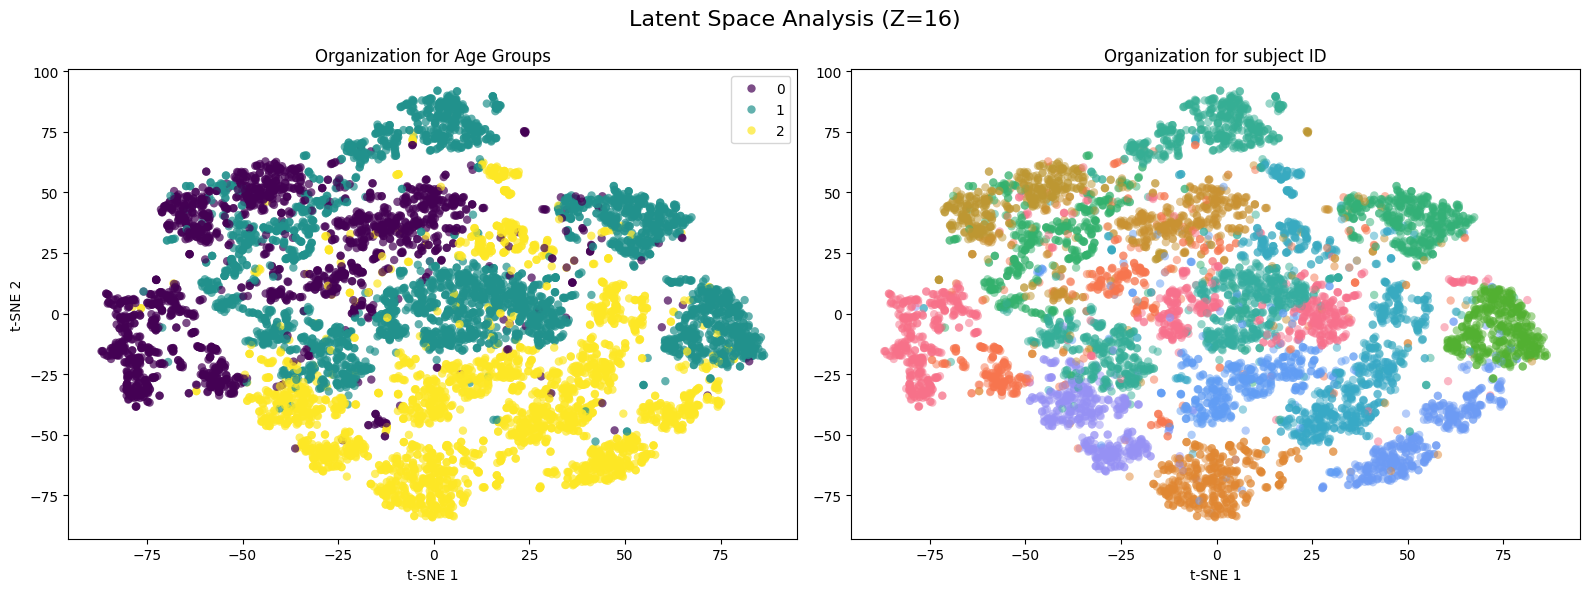

Número de puntos en el gráfico: 8160
Número de sujetos únicos: 17


In [32]:
# 2D tsne latents groups and subjects 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

#Z_t, yt, Y_subjt, logitst, meta_test,cid_test,stats_test = extract_latents_multi_epoch(test_loader, model, pack_batch, subject_to_idx,n_epochs=60, max_steps_per_epoch=None, device=device, return_meta_raw=True, verbose=False)

def plot_final_tsne(Z, y_group, subj_ids, title="Latent Space Analysis (Z=16)"):
    # 1. Calcular T-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    z_2d = tsne.fit_transform(Z)
    group_map = {0: 'Young', 1: 'Middle', 2: 'Older'}
    y_labels = [group_map[int(i)] for i in y_group]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Panel A: 
    sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=y_group, 
                    palette="viridis", ax=ax1, alpha=0.7, edgecolor='none')
    ax1.set_title("Organization for Age Groups")
    ax1.set_xlabel("t-SNE 1")
    ax1.set_ylabel("t-SNE 2")

    # Panel B: 
    sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=subj_ids, 
                    palette="husl", ax=ax2, alpha=0.5, edgecolor='none', legend=False)
    ax2.set_title("Organization for subject ID")
    ax2.set_xlabel("t-SNE 1")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_final_tsne(Zt, yt, subjt)

print(f"Número de puntos en el gráfico: {Zt.shape[0]}")
print(f"Número de sujetos únicos: {len(np.unique(subjt))}")

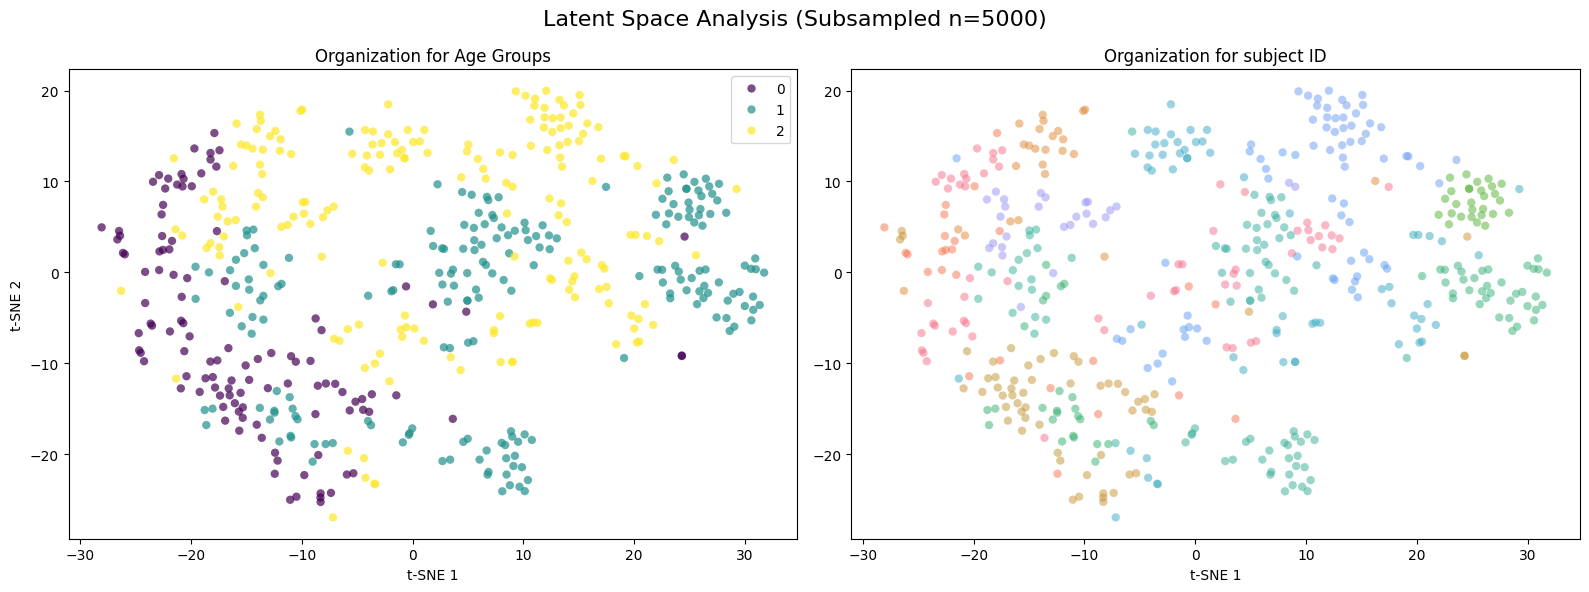

In [33]:
# 2D tsne latents groups and subjects (SUBSAMPLE)
#Z_t, yt, Y_subjt, logitst, meta_test,cid_test,stats_test = extract_latents_multi_epoch(test_loader, model, pack_batch, subject_to_idx,n_epochs=60, max_steps_per_epoch=None, device=device, return_meta_raw=True, verbose=False)
def plot_final_tsne(Z, y_group, subj_ids, title="Latent Space Analysis (Z=16)"):
    # 1. Calcular T-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    z_2d = tsne.fit_transform(Z)
    group_map = {0: 'Young', 1: 'Middle', 2: 'Older'}
    y_labels = [group_map[int(i)] for i in y_group]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Panel A: 
    sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=y_group, 
                    palette="viridis", ax=ax1, alpha=0.7, edgecolor='none')
    ax1.set_title("Organization for Age Groups")
    ax1.set_xlabel("t-SNE 1")
    ax1.set_ylabel("t-SNE 2")

    # Panel B: 
    sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=subj_ids, 
                    palette="husl", ax=ax2, alpha=0.5, edgecolor='none', legend=False)
    ax2.set_title("Organization for subject ID")
    ax2.set_xlabel("t-SNE 1")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

n_samples_plot = min(500, len(Zt_shuffled))

# 2. Generar índices aleatorios
indices_plot = np.random.choice(len(Zt_shuffled), n_samples_plot, replace=False)

# 3. Crear subconjuntos solo para el gráfico
Z_plot = Zt_shuffled[indices_plot]
y_plot = yt_shuffled[indices_plot]
s_plot = subjt_shuffled[indices_plot]

# 4. Graficar (ahora se verá mucho más nítido)
plot_final_tsne(Z_plot, y_plot, s_plot, title="Latent Space Analysis (Subsampled n=5000)")

In [18]:
# 3D tsne latents groups and subjects (SUBSAMPLED)
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE
def plot_latent_3d(Z, y_group, subj_ids):
    # 1. Calcular t-SNE en 3D
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
    z_3d = tsne_3d.fit_transform(Z)

    # 2. Preparar los datos
    group_map = {0: 'Young', 1: 'Middle', 2: 'Older'}
    df = pd.DataFrame({
        'TSNE1': z_3d[:, 0],
        'TSNE2': z_3d[:, 1],
        'TSNE3': z_3d[:, 2],
        'Age_Group': [group_map[int(i)] for i in y_group],
        'Subject_ID': [f"Subj_{s}" for s in subj_ids]
    })

    # 3. Crear el gráfico interactivo
    fig = px.scatter_3d(df, x='TSNE1', y='TSNE2', z='TSNE3',
                        color='Age_Group', 
                        symbol='Age_Group',
                        hover_data=['Subject_ID'],
                        title="Análisis 3D del Espacio Latente (Z=16)",
                        color_discrete_map={'Young': '#1f77b4', 'Middle': '#ff7f0e', 'Older': '#2ca02c'},
                        opacity=0.6)

    fig.update_traces(marker=dict(size=3))
    fig.show()

n_samples_plot = min(5000, len(Zt_shuffled))

# 2. Generar índices aleatorios
indices_plot = np.random.choice(len(Zt_shuffled), n_samples_plot, replace=False)

# 3. Crear subconjuntos solo para el gráfico
Z_plot = Zt_shuffled[indices_plot]
y_plot = yt_shuffled[indices_plot]
s_plot = subjt_shuffled[indices_plot]

# 4. Graficar (ahora se verá mucho más nítido)
plot_latent_3d(Z_plot, y_plot, s_plot)

##  Clustering 

In [34]:
#  --- IGNORE --- To check the random seed and batch composition
xs = []
subs = []
grps = []

it = iter(test_loader)
for _ in range(3):  # 3 batches
    x_batch, meta, cycle_id = next(it)
    subs.append(meta[:,0].cpu().numpy())
    grps.append(meta[:,1].cpu().numpy())
    xs.append(x_batch.shape[0])

print("batch_sizes:", xs)
print("first 20 subj ids:", np.concatenate(subs)[:20])
print("first 20 group ids:", np.concatenate(grps)[:20])

StopIteration: 

In [24]:
# --- IGNORE --- How pure are the batches in terms of subject composition?
purities = []
for i, (x, meta, *rest) in enumerate(test_loader):
    meta_np = meta[:,:].cpu().numpy()
    subj = meta_np[:,0].astype(int)
    # pureza del batch por sujeto
    vals, cnts = np.unique(subj, return_counts=True)
    purities.append(cnts.max()/cnts.sum())
    if i < 5:
        print("Batch", i, "purity:", purities[-1], "top subj:", vals[np.argmax(cnts)])

print("Mean batch subject-purity:", np.mean(purities))

Batch 0 purity: 0.058823529411764705 top subj: 2
Batch 1 purity: 0.058823529411764705 top subj: 2
Batch 2 purity: 0.058823529411764705 top subj: 2
Batch 3 purity: 0.058823529411764705 top subj: 2
Batch 4 purity: 0.058823529411764705 top subj: 2


KeyboardInterrupt: 

Unique GMM labels: [0 1 2]

=== GMM on SemiSupAE latent ===
Silhouette: 0.0727
ARI:        0.1898
NMI:        0.2078

=== External metrics (GMM) ===
Homogeneity:  0.2072
Completeness: 0.2085
V-measure:    0.2078

=== Cluster Purity (GMM) ===
Cluster 0: Purity = 0.6496, size = 3322
Cluster 1: Purity = 0.5310, size = 1793
Cluster 2: Purity = 0.5435, size = 3045

=== Internal structure metrics (GMM) ===
Calinski–Harabasz: 769.7
Davies–Bouldin:    3.0373

Accuracy after cluster→group mapping: 0.584


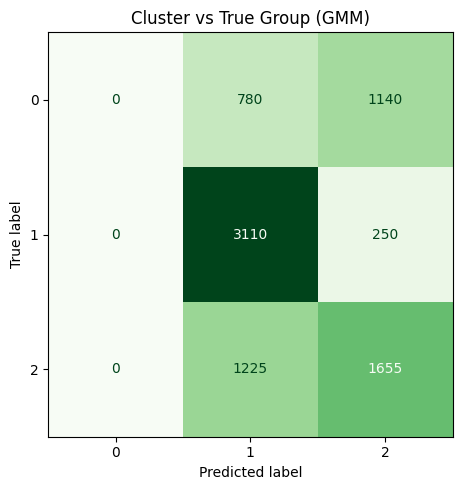

In [35]:
#Gaussian Mixture Model on SemiSupAE latents
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
      accuracy_score, classification_report,
      adjusted_rand_score, normalized_mutual_info_score,
    silhouette_score, davies_bouldin_score, homogeneity_score, completeness_score, v_measure_score,
    calinski_harabasz_score, f1_score, roc_auc_score
)
from collections import Counter
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


N_COMPONENTS = 3
RANDOM_STATE = 42

gmm = GaussianMixture(
    n_components=N_COMPONENTS,
    covariance_type="full",   #can try "diag" as well
    n_init=20,
    random_state=RANDOM_STATE
)
latents_scaled = scaler.fit_transform(Z_test)
gmm.fit(latents_scaled)
gmm_labels = gmm.predict(latents_scaled)
np.save("gmm_labels.npy", gmm_labels)
print("Unique GMM labels:", np.unique(gmm_labels))

# ── Basic external metrics ────────────────────────────────────────────────
sil_gmm = silhouette_score(latents_scaled, gmm_labels)
ari_gmm = adjusted_rand_score(Y_group_test, gmm_labels)
nmi_gmm = normalized_mutual_info_score(Y_group_test, gmm_labels)

print("\n=== GMM on SemiSupAE latent ===")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"ARI:        {ari_gmm:.4f}")
print(f"NMI:        {nmi_gmm:.4f}")

# ── External evaluation: homogeneity / completeness / V-measure ──────────
h_gmm = homogeneity_score(Y_group_test, gmm_labels)
c_gmm = completeness_score(Y_group_test, gmm_labels)
v_gmm = v_measure_score(Y_group_test, gmm_labels)

print("\n=== External metrics (GMM) ===")
print(f"Homogeneity:  {h_gmm:.4f}")
print(f"Completeness: {c_gmm:.4f}")
print(f"V-measure:    {v_gmm:.4f}")

# ── Cluster purity ────────────────────────────────────────────────────────
print("\n=== Cluster Purity (GMM) ===")
for cu in np.unique(gmm_labels):
    idxs = np.where(gmm_labels == cu)[0]
    # groups must be integer-coded for bincount
    purity = np.max(np.bincount(Y_group_test[idxs])) / len(idxs)
    print(f"Cluster {cu}: Purity = {purity:.4f}, size = {len(idxs)}")

# ── Internal structure metrics ────────────────────────────────────────────
ch_gmm = calinski_harabasz_score(latents_scaled, gmm_labels)
db_gmm = davies_bouldin_score(latents_scaled, gmm_labels)

print("\n=== Internal structure metrics (GMM) ===")
print(f"Calinski–Harabasz: {ch_gmm:.1f}")
print(f"Davies–Bouldin:    {db_gmm:.4f}")

# ── Cluster → group mapping (majority vote) ──────────────────────────────
mapping_gmm = {}
for cu in np.unique(gmm_labels):
    idxs = np.where(gmm_labels == cu)[0]
    most_common = Counter(Y_group_test[idxs]).most_common(1)[0][0]
    mapping_gmm[cu] = most_common

aligned_gmm = np.vectorize(mapping_gmm.get)(gmm_labels)
acc_gmm = (aligned_gmm == Y_group_test).mean()
print(f"\nAccuracy after cluster→group mapping: {acc_gmm:.3f}")

# ── Confusion matrix ─────────────────────────────────────────────────────
cm_gmm = confusion_matrix(Y_group_test, aligned_gmm)

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(cm_gmm).plot(
    cmap="Greens",
    ax=ax,
    values_format="d",
    colorbar=False
)
ax.set_title("Cluster vs True Group (GMM)")
plt.tight_layout()
plt.show()

=== HDBSCAN Clustering (Noise Ratio: 77.31%) ===
Clusters encontrados (excluyendo ruido): 5
Alineación con GRUPO  (Utilidad): ARI=0.6521, NMI=0.7271
Alineación con SUJETO (Privacidad): ARI=0.0000, NMI=0.0000

=== Detalle por Cluster (Pureza y Tamaño) ===
Cluster  0: Pureza=0.8171 | Tamaño=4560 | Grupo Dominante=0
Cluster  1: Pureza=0.9986 | Tamaño= 717 | Grupo Dominante=1
Cluster  2: Pureza=0.9993 | Tamaño=1471 | Grupo Dominante=2
Cluster  3: Pureza=1.0000 | Tamaño=2191 | Grupo Dominante=2
Cluster  4: Pureza=0.9992 | Tamaño=4933 | Grupo Dominante=1

=== Métricas de Estructura Interna (Solo puntos asignados) ===
Silhouette: 0.4370 | Calinski-Harabasz: 11864.7 | Davies-Bouldin: 0.9137

Exactitud tras mapeo Cluster -> Grupo: 0.9394


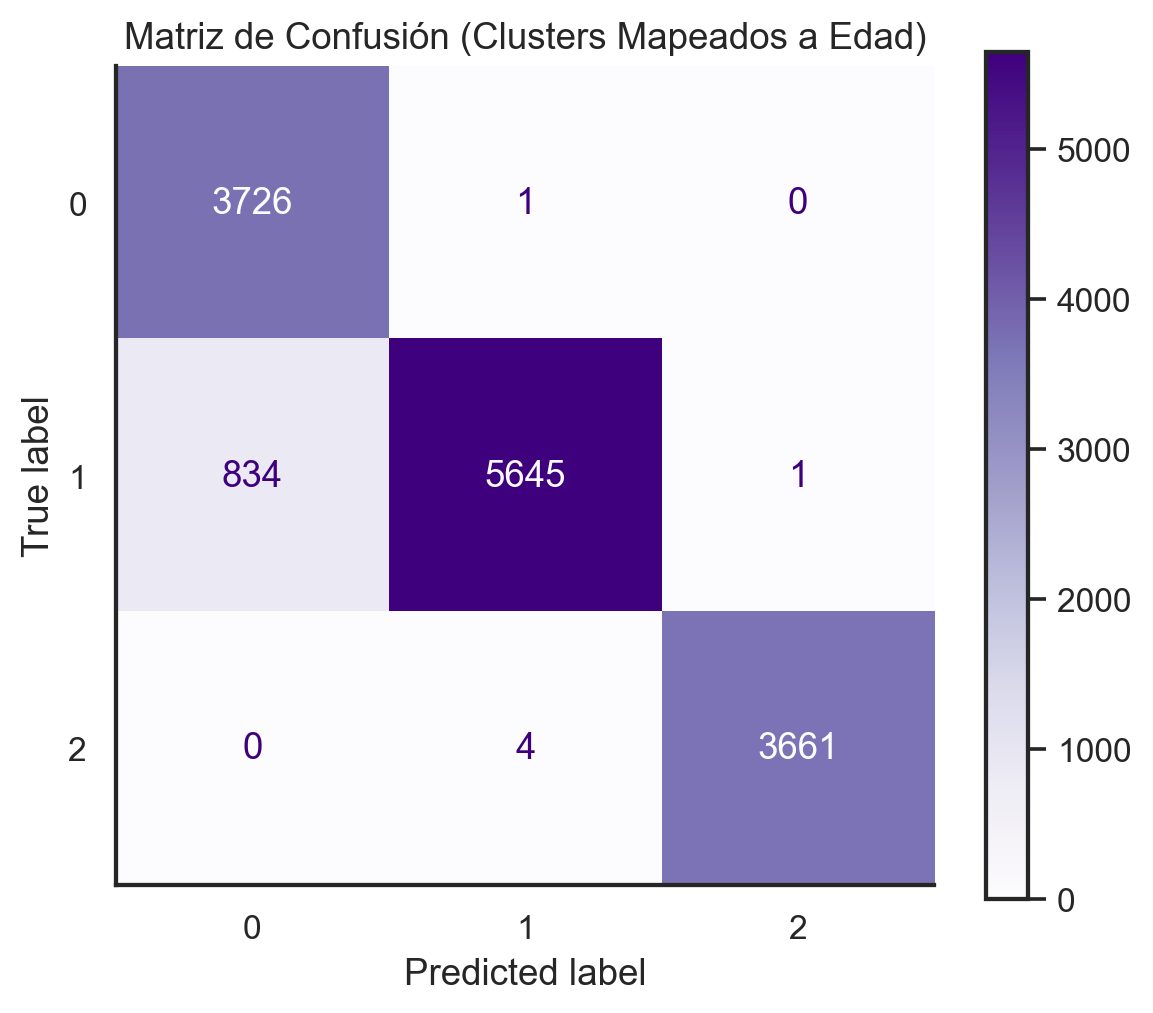

In [62]:
#HDBSCAN clustering on SemiSupAE latents ───────────────────────────────
import hdbscan 

scaler = StandardScaler()
latents_scaled = scaler.fit_transform(Z_test)

# --- 1. Ejecución de HDBSCAN ---
hdb = hdbscan.HDBSCAN(
    min_cluster_size=300, 
    min_samples=15,
    metric="euclidean"
)

hdb_labels = hdb.fit_predict(latents_scaled)
noise_mask = hdb_labels != -1

# --- 2. Extracción de subconjuntos válidos (sin ruido) ---
hdb_valid = hdb_labels[noise_mask]
latents_valid = latents_scaled[noise_mask]
groups_valid = Y_group_test[noise_mask]      # Edad
subjects_valid = Y_subj_test[noise_mask]  # Identidad (Sujeto)

# --- 3. Evaluación Dual: ¿Grupo o Sujeto? ---
def compute_alignment_metrics(true_labels, pred_labels, name="Group"):
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    return {f"ARI_{name}": ari, f"NMI_{name}": nmi}

met_group = compute_alignment_metrics(groups_valid, hdb_valid, "Group")
met_subj  = compute_alignment_metrics(subjects_valid, hdb_valid, "Subject")

print(f"=== HDBSCAN Clustering (Noise Ratio: {np.mean(~noise_mask)*100:.2f}%) ===")
print(f"Clusters encontrados (excluyendo ruido): {len(np.unique(hdb_valid))}")
print(f"Alineación con GRUPO  (Utilidad): ARI={met_group['ARI_Group']:.4f}, NMI={met_group['NMI_Group']:.4f}")
print(f"Alineación con SUJETO (Privacidad): ARI={met_subj['ARI_Subject']:.4f}, NMI={met_subj['NMI_Subject']:.4f}")

# Ratio de utilidad/privacidad: Un valor alto indica éxito del modelo adversarial
if met_subj['ARI_Subject'] > 0:
    print(f"Ratio Utilidad/Privacidad (ARI): {met_group['ARI_Group']/met_subj['ARI_Subject']:.2f}")

# --- 4. Pureza y Estructura por Cluster (Robusto con Counter) ---
print("\n=== Detalle por Cluster (Pureza y Tamaño) ===")
for cu in np.unique(hdb_valid):
    idxs = np.where(hdb_valid == cu)[0]
    counts = Counter(groups_valid[idxs])
    most_common_val, most_common_count = counts.most_common(1)[0]
    purity = most_common_count / len(idxs)
    print(f"Cluster {cu:2d}: Pureza={purity:.4f} | Tamaño={len(idxs):4d} | Grupo Dominante={most_common_val}")

# --- 5. Métricas Internas (Con salvaguarda estadística) ---
print("\n=== Métricas de Estructura Interna (Solo puntos asignados) ===")
n_unique_hdb = len(np.unique(hdb_valid))
if n_unique_hdb >= 2:
    sil = silhouette_score(latents_valid, hdb_valid)
    ch = calinski_harabasz_score(latents_valid, hdb_valid)
    db = davies_bouldin_score(latents_valid, hdb_valid)
    print(f"Silhouette: {sil:.4f} | Calinski-Harabasz: {ch:.1f} | Davies-Bouldin: {db:.4f}")
else:
    print("Métricas internas: N/A (Menos de 2 clusters encontrados)")

# --- 6. Mapping y Matriz de Confusión ---
mapping_hdb = {cu: Counter(groups_valid[np.where(hdb_valid == cu)[0]]).most_common(1)[0][0] 
               for cu in np.unique(hdb_valid)}

aligned_hdb = np.vectorize(mapping_hdb.get)(hdb_valid)
acc_mapping = (aligned_hdb == groups_valid).mean()

print(f"\nExactitud tras mapeo Cluster -> Grupo: {acc_mapping:.4f}")

# Visualización
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(groups_valid, aligned_hdb, cmap="Purples", ax=ax)
ax.set_title("Matriz de Confusión (Clusters Mapeados a Edad)")
plt.show()

Clusters per subject: count    15.000000
mean      1.266667
std       0.457738
min       1.000000
25%       1.000000
50%       1.000000
75%       1.500000
max       2.000000
Name: cluster, dtype: float64
Subjects per cluster: count    5.000000
mean     3.800000
std      1.643168
min      2.000000
25%      2.000000
50%      5.000000
75%      5.000000
max      5.000000
Name: subject, dtype: float64
Cluster sizes: count        6.000000
mean      6800.000000
std      12605.210589
min        599.000000
25%       1088.250000
50%       1960.000000
75%       2753.000000
max      32466.000000
Name: count, dtype: float64


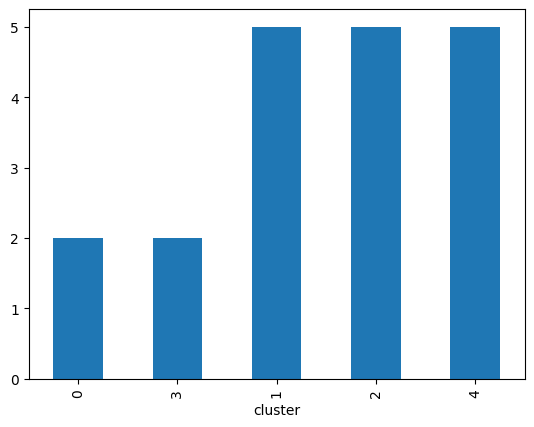

In [42]:
# Analyze number of clusters per subject
import pandas as pd
df = pd.DataFrame({
    "subject": subjt,
    "cluster": hdb_labels,
})

clusters_per_subject = (
    df[df.cluster >= 0]
    .groupby("subject")["cluster"]
    .nunique()
)

print("Clusters per subject:", clusters_per_subject.describe())

# Analyze number of subjects per cluster
subjects_per_cluster = (
    df[df.cluster >= 0]
    .groupby("cluster")["subject"]
    .nunique()
)

print("Subjects per cluster:", subjects_per_cluster.describe())

subjects_per_cluster.sort_values().plot(kind="bar")

cluster_sizes = pd.Series(hdb_labels).value_counts()
print("Cluster sizes:", cluster_sizes.describe())

In [40]:
def mean_dwell_time(labels):
    runs = []
    curr = labels[0]
    length = 1
    for l in labels[1:]:
        if l == curr:
            length += 1
        else:
            runs.append(length)
            curr = l
            length = 1
    runs.append(length)
    return np.mean(runs)

dwell = []
for subj in np.unique(subjt):
    seq = hdb_labels[subjt == subj]
    seq = seq[seq >= 0]
    if len(seq) > 0:
        dwell.append(mean_dwell_time(seq))

print("Mean dwell time:", np.mean(dwell))


Mean dwell time: 463.1944444444444


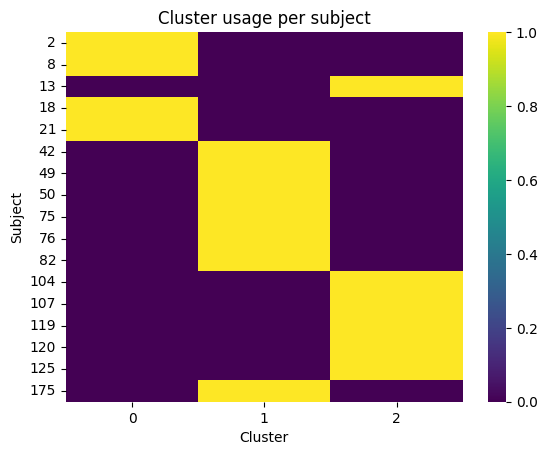

In [41]:
import seaborn as sns
pivot = (
    df[df.cluster >= 0]
    .pivot_table(index="subject", columns="cluster", aggfunc="size", fill_value=0)
)

pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

sns.heatmap(pivot_norm, cmap="viridis")
plt.title("Cluster usage per subject")
plt.xlabel("Cluster")
plt.ylabel("Subject")
plt.show()


In [44]:
# ¿Edad es linealmente separable en Z?
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, Zt, yt, cv=5, scoring='balanced_accuracy')

print("Balanced Acc (5-fold CV):", scores.mean())


Balanced Acc (5-fold CV): 0.8213723544973544


In [49]:
print(f"Shapes -> Z_lda: {Z_lda.shape}, yt: {len(yt)}")

Shapes -> Z_lda: (40800, 2), yt: 40800


/var/folders/c_/x_vllk0d7ns2ctmz7dqfpy240000gw/T/ipykernel_74476/43075560.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


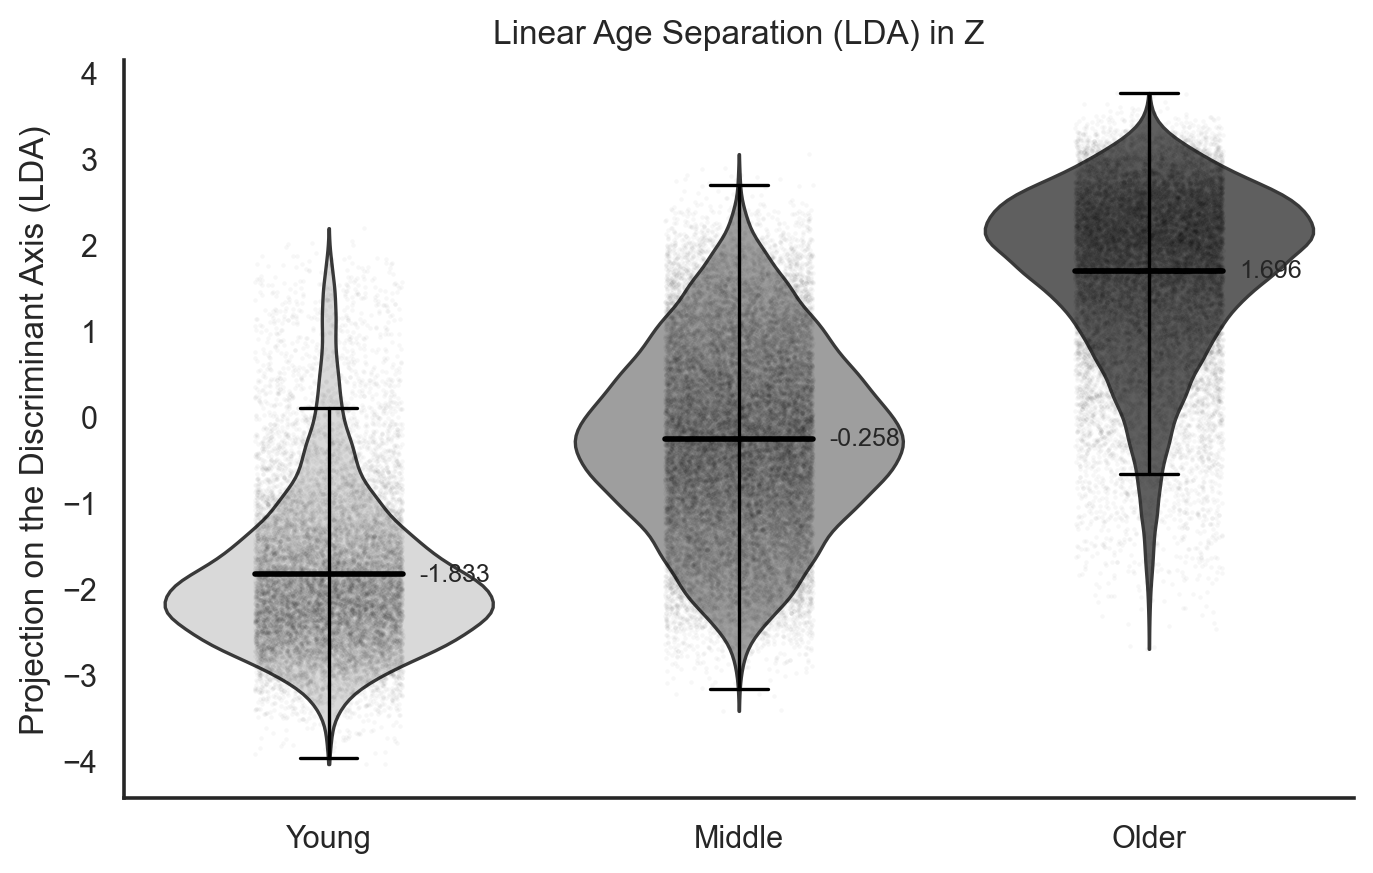

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# ----------------------------
# 1) LDA -> proyección al eje discriminante
# ----------------------------
lda = LinearDiscriminantAnalysis(n_components=2)
Z_lda = lda.fit_transform(Z_test, Y_group_test)

df_lda = pd.DataFrame({
    "Eje": Z_lda[:, 0],
    "Etiqueta": np.array(Y_group_test).flatten()
})

# ----------------------------
# 2) Labels bonitos + orden (ajusta a tu codificación real)
# ----------------------------
group_map = {0: "Young", 1: "Middle", 2: "Older"}
if np.issubdtype(df_lda["Etiqueta"].dtype, np.number):
    df_lda["group_lbl"] = df_lda["Etiqueta"].map(group_map)
else:
    df_lda["group_lbl"] = df_lda["Etiqueta"].astype(str)

order = ["Young", "Middle", "Older"]
# si alguna etiqueta no cae en esas tres, esto la dejará como NaN; si te pasa, comenta estas 2 líneas
df_lda["group_lbl"] = pd.Categorical(df_lda["group_lbl"], categories=order, ordered=True)
df_lda = df_lda.dropna(subset=["group_lbl"])

# ----------------------------
# 3) Estética tipo journal
# ----------------------------
sns.set_theme(style="white")
plt.rcParams.update({
    "figure.dpi": 200,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.3,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "font.size": 11
})

fig, ax = plt.subplots(figsize=(7, 4.5))

palette = ["#D9D9D9", "#9E9E9E", "#5F5F5F"]

# --- Violines ---
sns.violinplot(
    data=df_lda,
    x="group_lbl",
    y="Eje",
    order=order,
    cut=0,
    inner=None,
    linewidth=1.2,
    palette=palette,
    ax=ax
)

# --- Whiskers + mean line (manual, estilo box/whiskers encima del violin) ---
for i, g in enumerate(order):
    vals = df_lda.loc[df_lda["group_lbl"] == g, "Eje"].to_numpy()
    if len(vals) == 0:
        continue

    mean = np.mean(vals)
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    iqr = q3 - q1

    lower = vals[vals >= (q1 - 1.5 * iqr)].min()
    upper = vals[vals <= (q3 + 1.5 * iqr)].max()

    # whisker vertical
    ax.plot([i, i], [lower, upper], color="black", linewidth=1.2)

    # caps
    ax.plot([i - 0.07, i + 0.07], [lower, lower], color="black", linewidth=1.2)
    ax.plot([i - 0.07, i + 0.07], [upper, upper], color="black", linewidth=1.2)

    # mean horizontal line
    ax.plot([i - 0.18, i + 0.18], [mean, mean], color="black", linewidth=2)

    # mean label
    ax.text(i + 0.22, mean, f"{mean:.3f}", va="center", fontsize=9)

# --- Puntos (raw data) ---
# Nota: con ~40k puntos puede ponerse pesado.
# Si se traba, activa downsample (ej. 8000) o baja alpha/size.
downsample = None  # e.g., 8000
plot_df = df_lda if (downsample is None or downsample >= len(df_lda)) else df_lda.sample(downsample, random_state=0)

sns.stripplot(
    data=plot_df,
    x="group_lbl",
    y="Eje",
    order=order,
    color="black",
    alpha=0.20 if downsample else 0.03,  # muy bajo si estás graficando todo
    jitter=0.18,
    size=2.0 if downsample else 1.6,
    ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("Projection on the Discriminant Axis (LDA)")
ax.set_title("Linear Age Separation (LDA) in Z")

sns.despine()
plt.tight_layout()
plt.show()

Top 10 variables que definen el eje de envejecimiento (LD1):
       Feature      Peso  Abs_Peso
9    Feature_9  0.629815  0.629815
10  Feature_10  0.563830  0.563830
12  Feature_12 -0.559854  0.559854
15  Feature_15 -0.552888  0.552888
8    Feature_8 -0.294458  0.294458
7    Feature_7 -0.237139  0.237139
13  Feature_13 -0.212752  0.212752
6    Feature_6 -0.188710  0.188710
5    Feature_5 -0.138825  0.138825
4    Feature_4 -0.130066  0.130066


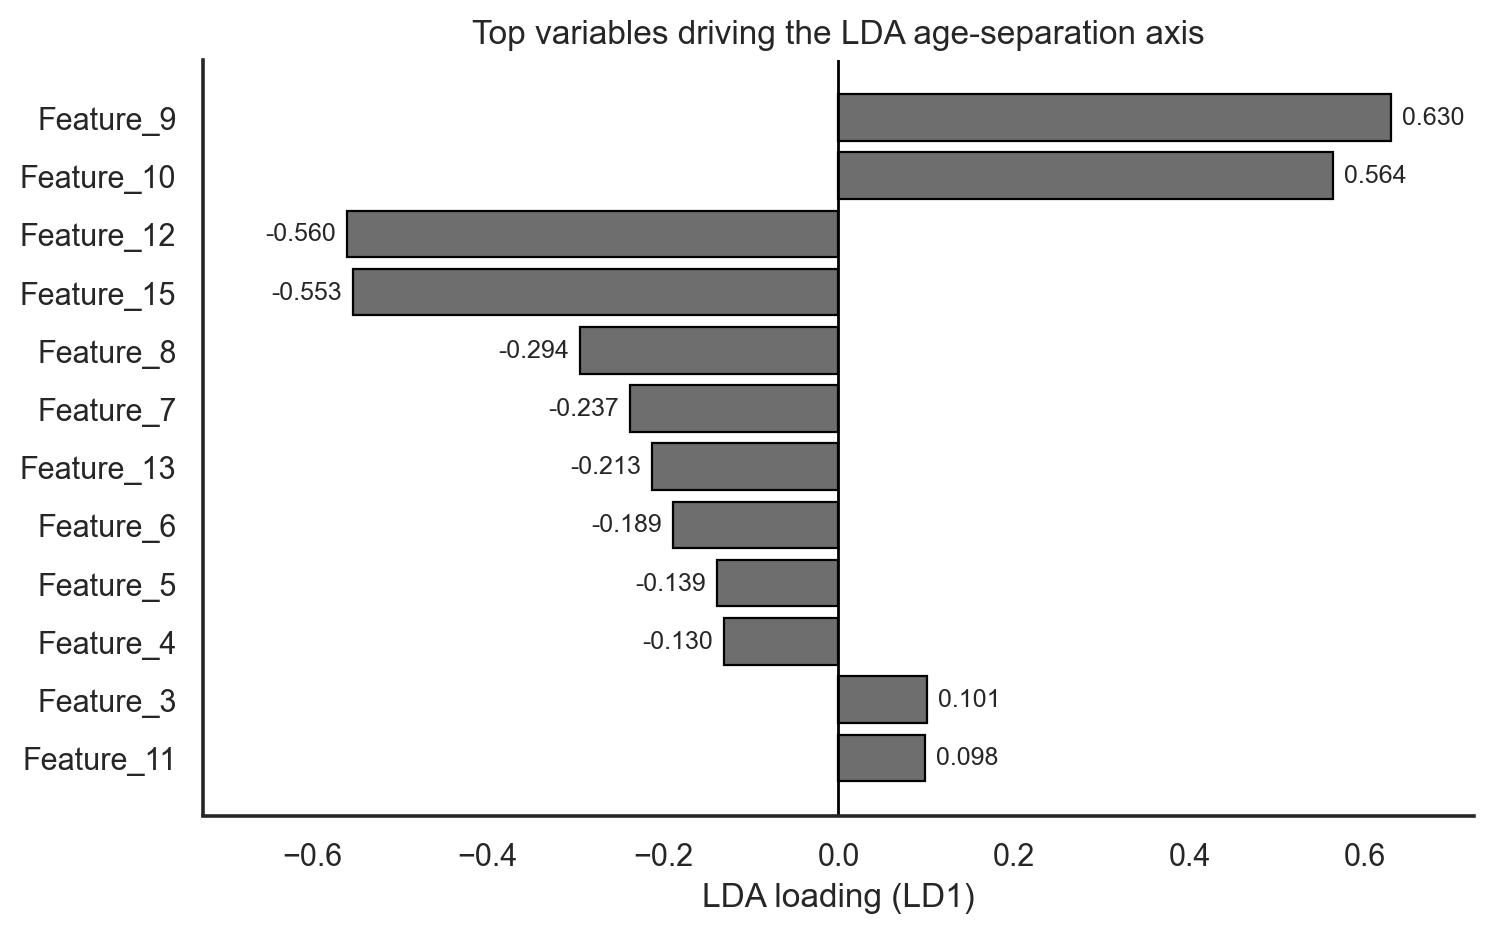

In [68]:
# Que variables impulsan esa separacion 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# 1) Pesos del eje discriminante (LD1)
# ----------------------------
pesos = lda.scalings_[:, 0]

# nombres de features
nombres_features = Z_test.columns if hasattr(Z_test, "columns") else [f"Feature_{i}" for i in range(Z_test.shape[1])]

df_pesos = pd.DataFrame({
    "Feature": nombres_features,
    "Peso": pesos
})
df_pesos["Abs_Peso"] = df_pesos["Peso"].abs()
df_pesos = df_pesos.sort_values("Abs_Peso", ascending=False)

print("Top 10 variables que definen el eje de envejecimiento (LD1):")
print(df_pesos.head(10))

# ----------------------------
# 2) Estética tipo journal
# ----------------------------
sns.set_theme(style="white")
plt.rcParams.update({
    "figure.dpi": 200,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.3,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "font.size": 11
})

# ----------------------------
# 3) Plot top-k
# ----------------------------
top_k = 12  # cambia a 10 si quieres exacto
top = df_pesos.head(top_k).copy()

# Para que la más importante quede arriba:
top = top.iloc[::-1].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(7.6, 4.8))

# Paleta gris (coherente con tu estilo)
bar_color = "#6E6E6E"

ax.barh(top["Feature"], top["Peso"], color=bar_color, edgecolor="black", linewidth=0.8)

# Línea en cero
ax.axvline(0, color="black", linewidth=1.0)

# Labels
ax.set_xlabel("LDA loading (LD1)")
ax.set_ylabel("")
ax.set_title("Top variables driving the LDA age-separation axis")

# Anotar valores al final de cada barra (formato corto)
xmax = np.max(np.abs(top["Peso"].values))
pad = 0.02 * xmax if xmax > 0 else 0.01

for y, (feat, w) in enumerate(zip(top["Feature"], top["Peso"])):
    # colocar texto a la derecha si w>0, a la izquierda si w<0
    if w >= 0:
        ax.text(w + pad, y, f"{w:.3f}", va="center", ha="left", fontsize=9)
    else:
        ax.text(w - pad, y, f"{w:.3f}", va="center", ha="right", fontsize=9)

# Limites con margen (para que quepan anotaciones)
ax.set_xlim(-1.15*xmax, 1.15*xmax)

sns.despine()
plt.tight_layout()
plt.show()

## PCA + LDA raw kinematics 

In [14]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def run_baseline_comparable(train_loader, test_loader, subject_to_idx):
    def collect_and_preprocess(loader, name="dataset"):
        X_list, y_g_list, y_s_list = [], [], []
        for i, batch_items in enumerate(loader):
            x_raw, meta0 = batch_items[0], batch_items[1]
            
            # Lógica de mapeo idéntica a tu modelo
            raw_pids = meta0[:, 0].long().tolist()
            mapped_pids = np.array([subject_to_idx.get(sid, 0) for sid in raw_pids])
            y_group = (meta0[:, 1].long() - 1).numpy()
            
            X_list.append(x_raw.reshape(x_raw.shape[0], -1).numpy())
            y_g_list.append(y_group)
            y_s_list.append(mapped_pids)
            if i >= 400: break # Seguridad para tu RAM en Omaha
            
        return np.concatenate(X_list), np.concatenate(y_g_list), np.concatenate(y_s_list)

    # Extracción
    X_train, y_g_train, y_s_train = collect_and_preprocess(train_loader, "Train")
    X_test, y_g_test, y_s_test = collect_and_preprocess(test_loader, "Test")

    # PCA al 95%
    pca = PCA(n_components=0.95, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Retornamos todo lo necesario para evitar NameError
    return {
        "X_train_pca": X_train_pca,
        "X_test_pca": X_test_pca,
        "y_g_train": y_g_train,
        "y_g_test": y_g_test,
        "y_s_train": y_s_train,
        "y_s_test": y_s_test
    }

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Asegurar loaders frescos
test_loader.dataset.infinite = False
train_loader.dataset.infinite = False

print(">>> Iniciando Baseline PCA + LDA + k-NN...", flush=True)

# Ejecución
res = run_baseline_comparable(train_loader, test_loader, subject_to_idx)

# --- EVALUACIÓN DE UTILIDAD (Edad vía LDA) ---
lda_age = LDA()
lda_age.fit(res["X_train_pca"], res["y_g_train"])
preds_age = lda_age.predict(res["X_test_pca"])
acc_edad = accuracy_score(res["y_g_test"], preds_age)

# --- EVALUACIÓN DE PRIVACIDAD (Sujeto vía k-NN) ---
# k=1 es el estándar para medir identificabilidad de "huella dactilar"
knn_subj = KNeighborsClassifier(n_neighbors=1)
knn_subj.fit(res["X_train_pca"], res["y_s_train"])
preds_subj = knn_subj.predict(res["X_test_pca"])
acc_priv = accuracy_score(res["y_s_test"], preds_subj)

print("\n" + "="*40)
print(f" RESULTADOS FINALES PIPELINE 2")
print("="*40)
print(f"UTILIDAD (Edad - LDA):   {acc_edad:.4f}")
print(f"PRIVACIDAD (Suj - kNN):  {acc_priv:.4f}")
print("="*40)

>>> Iniciando Baseline PCA + LDA + k-NN...

 RESULTADOS FINALES PIPELINE 2
UTILIDAD (Edad - LDA):   0.5441
PRIVACIDAD (Suj - kNN):  0.0000


In [17]:
from sklearn.neighbors import NearestNeighbors

def compute_baseline_privacy(X_pca, subjects):
    # k=2 porque el vecino más cercano a un punto es él mismo (distancia 0)
    # Queremos ver si el SEGUNDO vecino más cercano es del mismo sujeto
    nn = NearestNeighbors(n_neighbors=2, metric='euclidean')
    nn.fit(X_pca)
    distances, indices = nn.kneighbors(X_pca)
    
    # El índice en la posición [:, 1] es el vecino más cercano real
    neighbor_idx = indices[:, 1]
    neighbor_subjects = subjects[neighbor_idx]
    
    same_subject = (neighbor_subjects == subjects).sum()
    return same_subject / len(subjects)

# Cálculo de Privacidad Real sobre el set de Test
acc_priv_real = compute_baseline_privacy(res["X_test_pca"], res["y_s_test"])

print("\n" + "="*40)
print(f" RESULTADOS CORREGIDOS PIPELINE 2")
print("="*40)
print(f"UTILIDAD (Edad - LDA):      {acc_edad:.4f}")
print(f"PRIVACIDAD (Mismo Sujeto):  {acc_priv_real:.4f}")
print("="*40)


 RESULTADOS CORREGIDOS PIPELINE 2
UTILIDAD (Edad - LDA):      0.5441
PRIVACIDAD (Mismo Sujeto):  1.0000


## BCD 

In [ ]:
#Data loader 
bs = 2048
test_ds = GaitBatchIterable(
        store_path="test_cycles.zarr",
        batch_size=bs,
        return_meta=True,
        shuffle=False,
        seed=42
    )

test_loader = DataLoader(
    test_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,
)



In [38]:
# Calculate the Z for test including all the cycles 
Z_test, Y_group_test, Y_subj_test, _, meta_test = extract_latents(test_loader, model, pack_batch, subject_to_idx, device=device, return_meta_raw=True)
Z_train, Y_group_train, Y_subj_train, _, meta_train = extract_latents(train_loader, model, pack_batch, subject_to_idx, max_steps=200, device=device, return_meta_raw=True)
Z_val, Y_group_val, Y_subj_val, _, meta_val = extract_latents(val_loader, model, pack_batch, subject_to_idx, max_steps=200, device=device, return_meta_raw=True)
meta = np.asarray(meta_test)
unique_rows = np.unique(meta, axis=0).shape[0]
print("N:", meta.shape[0], "unique meta rows:", unique_rows)

DEBUG: y_group unique in first batch: [0 1 2]


In [18]:
# Helper Functions 
# BCD on Latents (TEST) using: Age Axis + 2 Orthogonal PCs
# Unit of analysis: (subject_raw, day_raw, session, trial)
# Notes:
# - Fit LDA + residual PCA + normalization ONLY on TRAIN
# - Apply transforms to TEST and compute BCD per trial
# - Comments in English (as you prefer)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# -----------------------------
# 0) Helpers: project + normalize
# -----------------------------
def _unit(v, eps=1e-12):
    n = np.linalg.norm(v)
    return v / (n + eps)

def project_age_residual(Z, w_unit):
    """
    Z: (N,d)
    w_unit: (d,)
    Returns:
      a: (N,)  age-axis coordinate
      Z_perp: (N,d) residual orthogonal to age axis
    """
    a = Z @ w_unit
    Z_perp = Z - np.outer(a, w_unit)
    return a, Z_perp

def project_3d(Z, w_unit, pca_res):
    """
    3D coordinates = [age_axis, pc1_residual, pc2_residual]
    """
    a, Zp = project_age_residual(Z, w_unit)
    P = pca_res.transform(Zp)  # (N,2)
    X3 = np.column_stack([a, P[:, 0], P[:, 1]])
    return X3

def fit_train_transforms(Z_train, y_group_train):
    """
    Fit age axis (LDA) and residual PCA on TRAIN only.
    y_group_train must be in {0,1,2}.
    Returns: dict with w_unit, pca_res, mu, sd
    """
    # LDA age axis
    lda = LinearDiscriminantAnalysis(n_components=1)
    lda.fit(Z_train, y_group_train)
    w = lda.scalings_[:, 0]          # (d,)
    w_unit = _unit(w)

    # Residual PCA (orthogonal to age axis)
    _, Zp_tr = project_age_residual(Z_train, w_unit)
    pca_res = PCA(n_components=2, random_state=0)
    pca_res.fit(Zp_tr)

    # Train stats for normalization in 3D
    X3_tr = project_3d(Z_train, w_unit, pca_res)
    mu = X3_tr.mean(axis=0)
    sd = X3_tr.std(axis=0) + 1e-12

    return {"w_unit": w_unit, "pca_res": pca_res, "mu": mu, "sd": sd}

def apply_transforms(Z, tr):
    """
    Apply TRAIN-fit transforms to any split (TRAIN/VAL/TEST).
    Returns normalized 3D coordinates (N,3).
    """
    X3 = project_3d(Z, tr["w_unit"], tr["pca_res"])
    X3n = (X3 - tr["mu"]) / tr["sd"]
    return X3n

# -----------------------------
# 1) Box-Counting Dimension (BCD)
# -----------------------------
def box_counting_dimension(X, n_eps=12):
    """
    X: (N,3) normalized coords.
    Returns slope D of log N(eps) vs log(1/eps).
    """
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    span = np.maximum(maxs - mins, 1e-12)

    # Epsilon range: avoid degenerate regimes
    eps_max = span.max() / 2.0
    eps_min = span.max() / 50.0
    eps = np.geomspace(eps_max, eps_min, n_eps)

    logs_inv, logs_N = [], []
    N = X.shape[0]

    for e in eps:
        idx = np.floor((X - mins) / e).astype(np.int64)
        n_boxes = np.unique(idx, axis=0).shape[0]

        # Keep only informative scales
        if 1 < n_boxes < (N / 2):
            logs_inv.append(np.log(1.0 / e))
            logs_N.append(np.log(n_boxes))

    if len(logs_inv) < 3:
        return np.nan

    D, _c = np.polyfit(logs_inv, logs_N, 1)
    return float(D)

def bcd_with_subsample_bootstrap(X, min_cycles=150, n_fixed=200, boot=20, seed=0):
    """
    Compute BCD for one unit (trial). Subsample to n_fixed if needed.
    """
    N = X.shape[0]
    if N < min_cycles:
        return np.nan

    if N <= n_fixed:
        return box_counting_dimension(X)

    rng = np.random.default_rng(seed)
    Ds = []
    for b in range(boot):
        sel = rng.choice(N, size=n_fixed, replace=False)
        D = box_counting_dimension(X[sel])
        if not np.isnan(D):
            Ds.append(D)
    return float(np.mean(Ds)) if Ds else np.nan

# -----------------------------
# 2) Meta parsing and grouping (subject/day/session/trial)
# -----------------------------
def parse_meta_raw(meta_raw):
    """
    meta_raw: (N,5) columns:
      [subj_raw, group_raw(1..3), day_raw, session, trial]
    Returns dict of arrays.
    """
    meta_raw = np.asarray(meta_raw)
    if meta_raw.shape[1] < 5:
        raise ValueError(f"Expected meta_raw with >=5 cols, got shape {meta_raw.shape}")

    subj_raw  = meta_raw[:, 0].astype(int)
    group_raw = meta_raw[:, 1].astype(int)
    day_raw   = meta_raw[:, 2].astype(int)
    session   = meta_raw[:, 3].astype(int)
    trial     = meta_raw[:, 4].astype(int)

    group = group_raw - 1  # 0,1,2

    return {
        "subj_raw": subj_raw,
        "group": group,
        "group_raw": group_raw,
        "day_raw": day_raw,
        "session": session,
        "trial": trial,
    }

def compute_bcd_per_trial_df(X3n, meta_raw, min_cycles=150, n_fixed=200, boot=20):
    """
    X3n: (N,3) normalized coords for a split (typically TEST)
    meta_raw: (N,5) raw metadata aligned 1:1 with X3n rows
    Returns DataFrame with one row per (subject_raw, day_raw, session, trial)
    """
    m = parse_meta_raw(meta_raw)
    subj_raw = m["subj_raw"]
    group    = m["group"]
    day_raw  = m["day_raw"]
    session  = m["session"]
    trial    = m["trial"]

    # Build keys per row
    keys = list(zip(subj_raw, day_raw, session, trial))

    # Group indices by key
    idx_by_key = {}
    for i, k in enumerate(keys):
        idx_by_key.setdefault(k, []).append(i)

    rows = []
    for (s, d, sess, tr), idxs in idx_by_key.items():
        X_unit = X3n[idxs, :]
        D = bcd_with_subsample_bootstrap(
            X_unit, min_cycles=min_cycles, n_fixed=n_fixed, boot=boot, seed=0
        )

        # group should be constant within key; take first
        g = int(group[idxs[0]])

        rows.append({
            "subject_raw": s,
            "group": g,               # 0,1,2
            "day_raw": d,
            "session": sess,
            "trial": tr,
            "n_cycles": len(idxs),
            "BCD": D
        })

    df = pd.DataFrame(rows).sort_values(["subject_raw", "day_raw", "session", "trial"]).reset_index(drop=True)
    return df




In [19]:
# BCD 
# 3) MAIN: Fit transforms on TRAIN, compute BCD on TEST
# -----------------------------
# Expected inputs you already have:
#   Z_train: (N_train,16)
#   Y_group_train: (N_train,) in {0,1,2}  (from pack_batch)
#   Z_test: (N_test,16)
#   meta_test: (N_test,5) raw metadata from meta0[:, :5]


# ---- Fit TRAIN transforms ----
tr = fit_train_transforms(Z_train, Y_group_train)

# ---- Project TEST to interpretable 3D (normalized) ----
X3n_test = apply_transforms(Z_test, tr)

# ---- Compute BCD per trial (TEST) ----
bcd_trial_df = compute_bcd_per_trial_df(
    X3n_test, meta_test,
    min_cycles=60,   # adjust if needed after inspecting n_cycles distribution
    n_fixed=80,      # equalize sample size per trial
    boot=20           # bootstrap subsamples for stability
)

print("BCD per trial (TEST) head:")
print(bcd_trial_df.head(10))

print("\nSanity checks:")
print("NaN BCD count:", bcd_trial_df["BCD"].isna().sum())
print("n_trials:", len(bcd_trial_df))
print("n_subjects:", bcd_trial_df["subject_raw"].nunique())
print("n_cycles stats:", bcd_trial_df["n_cycles"].describe())

# Optional: aggregate per subject to avoid pseudo-replication in quick tests
bcd_subject_df = (
    bcd_trial_df.dropna(subset=["BCD"])
    .groupby(["subject_raw", "group"], as_index=False)
    .agg(BCD_mean=("BCD", "mean"), BCD_median=("BCD", "median"), n_trials=("BCD", "size"))
)

print("\nBCD per subject (TEST) head:")
print(bcd_subject_df.head(10))

BCD per trial (TEST) head:
   subject_raw  group  day_raw  session  trial  n_cycles       BCD
0            2      0        1        1      1       183  1.699865
1            2      0        1        1      2       180  1.542557
2            2      0        1        1      3       178  1.535067
3            2      0        1        2      1       178  1.611918
4            2      0        1        2      2       182  1.662016
5            2      0        1        2      3       182  1.550572
6            2      0        1        3      1       180  1.561302
7            2      0        1        3      2       178  1.535944
8            2      0        1        3      3       180  1.650758
9            2      0        2        1      1       182  1.652049

Sanity checks:
NaN BCD count: 0
n_trials: 295
n_subjects: 17
n_cycles stats: count    295.000000
mean     207.261017
std       22.501466
min       79.000000
25%      192.500000
50%      210.000000
75%      225.000000
max      256.00000

In [20]:
# Metrics for BCD 
print(bcd_trial_df["BCD"].describe())
print(bcd_trial_df.groupby("group")["BCD"].describe())
print("NaNs:", bcd_trial_df["BCD"].isna().sum())


count    295.000000
mean       1.556064
std        0.133769
min        0.982301
25%        1.489475
50%        1.559698
75%        1.634844
max        1.937076
Name: BCD, dtype: float64
       count      mean       std       min       25%       50%       75%  \
group                                                                      
0       72.0  1.597937  0.095869  1.398125  1.526683  1.600410  1.653832   
1      126.0  1.579031  0.106414  1.249245  1.515125  1.575911  1.642907   
2       97.0  1.495151  0.165838  0.982301  1.405407  1.494039  1.588682   

            max  
group            
0      1.819470  
1      1.901608  
2      1.937076  
NaNs: 0


In [21]:
# Effect per day 
bcd_trial_df.groupby(["group","day_raw"])["BCD"].mean()


group  day_raw
0      1          1.597344
       2          1.598530
1      1          1.579198
       2          1.578864
2      1          1.495075
       2          1.495238
Name: BCD, dtype: float64

In [22]:
#Effect per subject not trial 
bcd_subject_df.groupby("group")["BCD_mean"].mean()


group
0    1.597937
1    1.579031
2    1.515062
Name: BCD_mean, dtype: float64

In [23]:
#Kruskal 
from scipy.stats import kruskal

g0 = bcd_trial_df[bcd_trial_df.group==0]["BCD"]
g1 = bcd_trial_df[bcd_trial_df.group==1]["BCD"]
g2 = bcd_trial_df[bcd_trial_df.group==2]["BCD"]

kruskal(g0, g1, g2)


KruskalResult(statistic=np.float64(29.962964775451724), pvalue=np.float64(3.1161967355682523e-07))

In [70]:
#Kruskal subject level 
from scipy.stats import kruskal

g0 = bcd_subject_df[bcd_subject_df.group==0]["BCD_mean"]
g1 = bcd_subject_df[bcd_subject_df.group==1]["BCD_mean"]
g2 = bcd_subject_df[bcd_subject_df.group==2]["BCD_mean"]

kruskal(g0, g1, g2)

KruskalResult(statistic=np.float64(3.2768440709617224), pvalue=np.float64(0.1942863775445648))

/var/folders/c_/x_vllk0d7ns2ctmz7dqfpy240000gw/T/ipykernel_74476/27984895.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


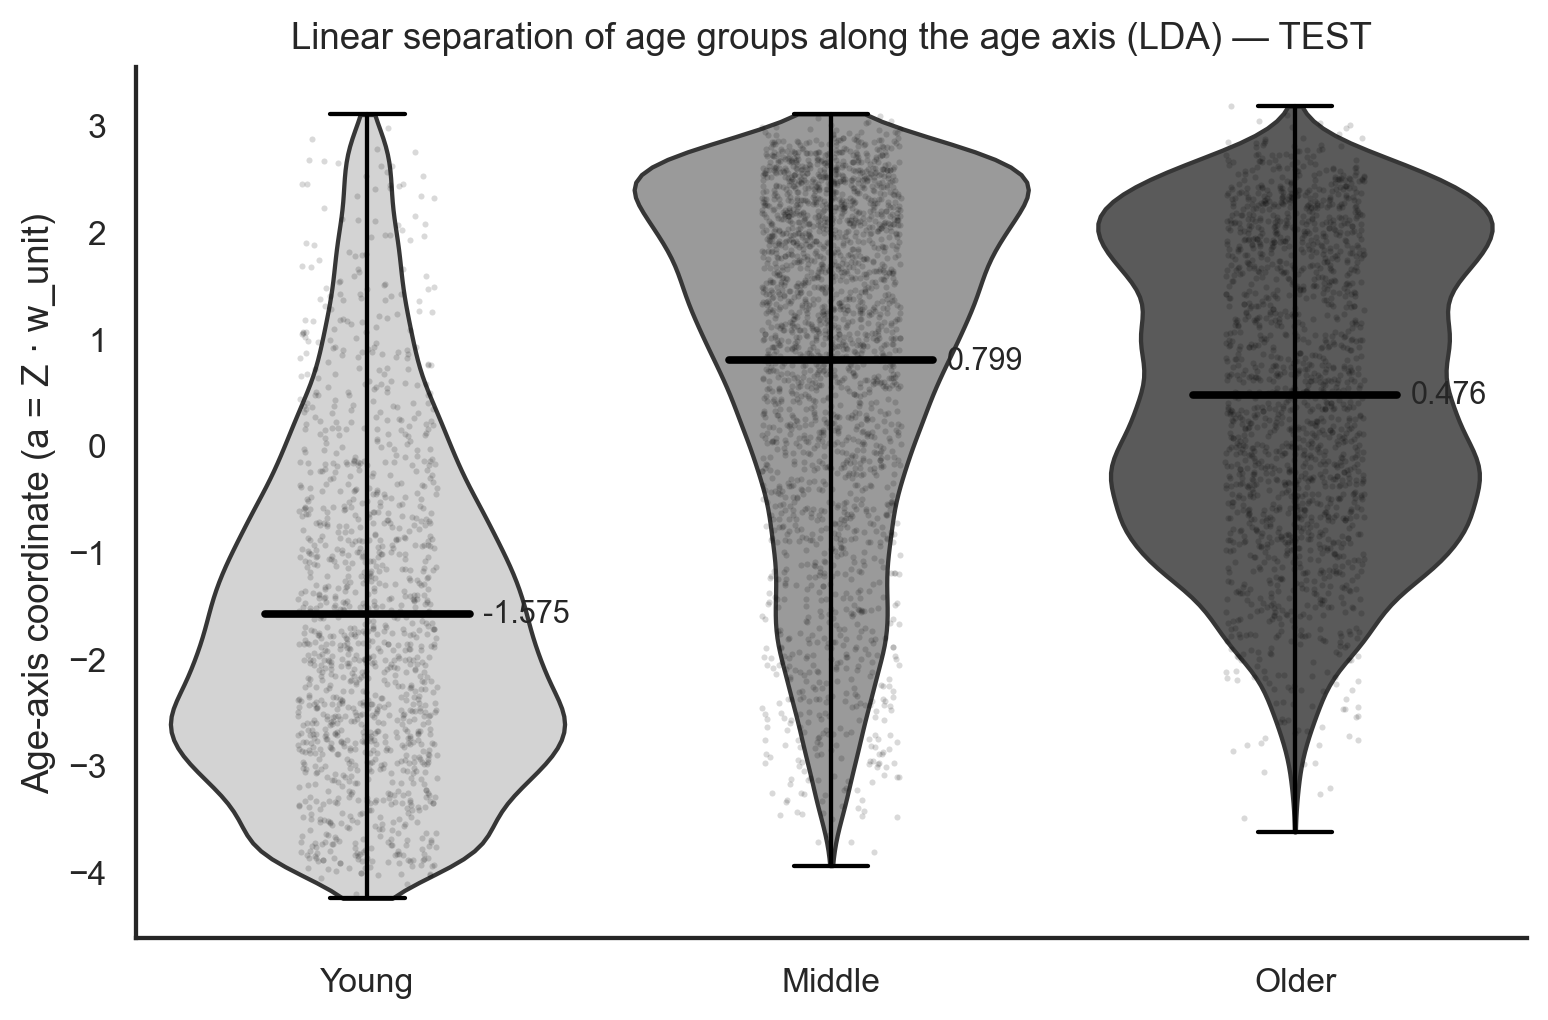


[TEST] One-way ANOVA on age-axis
  F = 12176.753, p = 0.000e+00, eta^2 = 0.2849

[TEST] Spearman (age group ordinal vs axis)
  rho = 0.342, p = 0.000e+00

[TEST] Pairwise Cohen's d (axis separation)
  pair  cohens_d
0 vs 1 -1.474467
1 vs 2  0.212633
0 vs 2 -1.389915

[TEST] Permutation test (eta^2)
  eta^2_obs = 0.2849, p_emp = 0.0005


In [39]:
#IGNORAR AHORA 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import f_oneway, spearmanr

# -----------------------------
# 0) Helpers: unit + project
# -----------------------------
def _unit(v, eps=1e-12):
    n = np.linalg.norm(v)
    return v / (n + eps)

def age_axis_from_train_lda(Z_train, y_group_train):
    """
    Fit LDA on TRAIN only and return unit vector w_unit.
    """
    lda = LinearDiscriminantAnalysis(n_components=1)
    lda.fit(Z_train, y_group_train)
    w = lda.scalings_[:, 0]          # (d,)
    return _unit(w)

def project_age_axis(Z, w_unit):
    """
    Pure projection: a = Z · w_unit
    """
    return Z @ w_unit

def maybe_center(a, mode="none"):
    """
    mode:
      - "none": do nothing
      - "global": subtract global mean
      - "per_split": subtract split mean (solo visual; NO recomendado si comparas niveles entre splits)
    """
    if mode == "none":
        return a
    if mode == "global":
        return a - np.mean(a)
    if mode == "per_split":
        return a - np.mean(a)
    raise ValueError("mode must be one of {'none','global','per_split'}")

def maybe_flip_for_interpretability(a_train, y_train, w_unit, group_order=(0,1,2)):
    """
    Flip sign ONLY if needed so that mean increases with group label (0<1<2).
    This is NOT forcing results; w and -w are equivalent in LDA.
    Returns possibly flipped w_unit.
    """
    df = pd.DataFrame({"a": a_train, "g": np.array(y_train).astype(int)})
    means = df.groupby("g")["a"].mean()
    # if Older mean < Young mean, flip
    if means.loc[group_order[-1]] < means.loc[group_order[0]]:
        return -w_unit
    return w_unit

# -----------------------------
# 1) Stats: eta^2, Cohen's d, permutation
# -----------------------------
def eta_squared_oneway(a, y):
    """
    One-way ANOVA effect size eta^2.
    """
    y = np.array(y).astype(int)
    groups = [a[y == k] for k in np.unique(y)]
    grand_mean = np.mean(a)
    ss_between = sum(len(g)*(np.mean(g)-grand_mean)**2 for g in groups)
    ss_total = np.sum((a - grand_mean)**2)
    eta2 = ss_between / (ss_total + 1e-12)
    # p-value from ANOVA
    F, p = f_oneway(*groups)
    return eta2, F, p

def cohens_d(x, y):
    """
    Cohen's d for two samples x,y (pooled SD).
    """
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    sp = np.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx+ny-2 + 1e-12))
    d = (np.mean(x) - np.mean(y)) / (sp + 1e-12)
    return d

def pairwise_cohens_d(a, y, pairs=((0,1),(1,2),(0,2))):
    y = np.array(y).astype(int)
    out = []
    for i,j in pairs:
        d = cohens_d(a[y==i], a[y==j])
        out.append({"pair": f"{i} vs {j}", "cohens_d": d})
    return pd.DataFrame(out)

def permutation_test_eta2(a, y, n_perm=2000, seed=0):
    """
    Permutation test on eta^2 (group labels shuffled).
    Returns empirical p-value (eta2_perm >= eta2_obs).
    """
    rng = np.random.default_rng(seed)
    eta2_obs, _, _ = eta_squared_oneway(a, y)
    y = np.array(y).astype(int)
    count = 0
    for _ in range(n_perm):
        y_perm = rng.permutation(y)
        eta2_perm, _, _ = eta_squared_oneway(a, y_perm)
        if eta2_perm >= eta2_obs:
            count += 1
    p_emp = (count + 1) / (n_perm + 1)
    return eta2_obs, p_emp

# -----------------------------
# 2) Plot: NONAN style violin + whiskers + mean line + label
# -----------------------------
def plot_age_axis_nonan_style(
    a, y,
    group_map={0:"Young", 1:"Middle", 2:"Older"},
    order=("Young","Middle","Older"),
    title="Age-axis projection (LDA)",
    ylabel="Age-axis coordinate (a = Z · w_unit)",
    whisker_mode="tukey",   # "tukey" or "minmax"
    max_points=5000,
    seed=0,
    mean_decimals=3
):
    df = pd.DataFrame({"AgeAxis": a, "group": np.array(y).astype(int)})
    df["group_lbl"] = df["group"].map(group_map)
    df["group_lbl"] = pd.Categorical(df["group_lbl"], categories=list(order), ordered=True)

    sns.set_theme(style="white")
    plt.rcParams.update({
        "figure.dpi": 220,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 1.4,
        "xtick.major.width": 1.2,
        "ytick.major.width": 1.2,
        "font.size": 12
    })

    fig, ax = plt.subplots(figsize=(7.2, 4.8))
    palette = ["#D3D3D3", "#9A9A9A", "#5A5A5A"]

    sns.violinplot(
        data=df, x="group_lbl", y="AgeAxis",
        order=list(order),
        cut=0, inner=None,
        width=0.85,
        linewidth=1.4,
        palette=palette,
        ax=ax
    )

    for i, g in enumerate(order):
        vals = df.loc[df["group_lbl"] == g, "AgeAxis"].dropna().values
        if len(vals) == 0:
            continue

        mean = float(np.mean(vals))

        if whisker_mode == "minmax":
            lower, upper = float(np.min(vals)), float(np.max(vals))
        else:
            q1 = np.percentile(vals, 25)
            q3 = np.percentile(vals, 75)
            iqr = q3 - q1
            lower = vals[vals >= (q1 - 1.5*iqr)].min()
            upper = vals[vals <= (q3 + 1.5*iqr)].max()

        # vertical whisker + caps
        ax.plot([i,i], [lower, upper], color="black", linewidth=1.4)
        ax.plot([i-0.08, i+0.08], [lower, lower], color="black", linewidth=1.4)
        ax.plot([i-0.08, i+0.08], [upper, upper], color="black", linewidth=1.4)

        # mean line
        ax.plot([i-0.22, i+0.22], [mean, mean], color="black", linewidth=2.5)

        # mean label
        ax.text(i+0.25, mean, f"{mean:.{mean_decimals}f}", va="center", fontsize=10)

    # points (subsample)
    rng = np.random.default_rng(seed)
    if max_points is not None and len(df) > max_points:
        df_pts = df.sample(n=max_points, random_state=seed)
    else:
        df_pts = df

    sns.stripplot(
        data=df_pts, x="group_lbl", y="AgeAxis",
        order=list(order),
        color="black",
        alpha=0.15,
        jitter=0.15,
        size=2.0,
        ax=ax
    )

    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 3) End-to-end: fit on TRAIN, apply to splits, stats on TEST
# -----------------------------
def run_age_axis_analysis(
    Z_train, y_train,
    Z_val, y_val,
    Z_test, y_test,
    center_mode="none",          # "none" or "global"
    flip_sign=False,             # True para orientarlo interpretativamente
    whisker_mode="tukey",
    do_permutation=True,
    n_perm=2000,
    seed=0
):
    # Fit axis on TRAIN only
    w_unit = age_axis_from_train_lda(Z_train, y_train)

    # Project
    a_train = project_age_axis(Z_train, w_unit)
    if flip_sign:
        w_unit = maybe_flip_for_interpretability(a_train, y_train, w_unit)
        a_train = project_age_axis(Z_train, w_unit)

    a_val  = project_age_axis(Z_val,  w_unit)
    a_test = project_age_axis(Z_test, w_unit)

    # Optional centering (global mean from TRAIN recommended)
    if center_mode == "global":
        mu = np.mean(a_train)
        a_train = a_train - mu
        a_val   = a_val   - mu
        a_test  = a_test  - mu

    # ---- Plot TEST (recomendado para paper) ----
    plot_age_axis_nonan_style(
        a_test, y_test,
        title="Linear separation of age groups along the age axis (LDA) — TEST",
        ylabel="Age-axis coordinate (a = Z · w_unit)",
        whisker_mode=whisker_mode,
        seed=seed
    )

    # ---- Stats on TEST ----
    eta2, F, p = eta_squared_oneway(a_test, y_test)
    d_pairs = pairwise_cohens_d(a_test, y_test)
    rho, p_rho = spearmanr(a_test, np.array(y_test).astype(int))  # ordinal trend

    print("\n[TEST] One-way ANOVA on age-axis")
    print(f"  F = {F:.3f}, p = {p:.3e}, eta^2 = {eta2:.4f}")

    print("\n[TEST] Spearman (age group ordinal vs axis)")
    print(f"  rho = {rho:.3f}, p = {p_rho:.3e}")

    print("\n[TEST] Pairwise Cohen's d (axis separation)")
    print(d_pairs.to_string(index=False))

    if do_permutation:
        eta2_obs, p_emp = permutation_test_eta2(a_test, y_test, n_perm=n_perm, seed=seed)
        print("\n[TEST] Permutation test (eta^2)")
        print(f"  eta^2_obs = {eta2_obs:.4f}, p_emp = {p_emp:.4f}")

    return {
        "w_unit": w_unit,
        "a_train": a_train, "a_val": a_val, "a_test": a_test,
        "eta2_test": eta2, "F_test": F, "p_test": p,
        "spearman_rho": rho, "spearman_p": p_rho,
        "d_pairs_test": d_pairs
    }

# -----------------------------
# 4) Example call
# -----------------------------
results = run_age_axis_analysis(
    Z_train, Y_group_train,
    Z_val, Y_group_val,
    Z_test, Y_group_test,
    center_mode="global",   # recomendado si quieres centrar con TRAIN
    flip_sign=False,        # primero mira el orden "natural" sin flip
    whisker_mode="minmax",  # como tu figura (parece min-max) o "tukey"
    do_permutation=True,
    n_perm=2000,
    seed=0
)

# Si ves que el eje sale invertido, entonces:
# results = run_age_axis_analysis(..., flip_sign=True)

/var/folders/c_/x_vllk0d7ns2ctmz7dqfpy240000gw/T/ipykernel_74476/1362654243.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


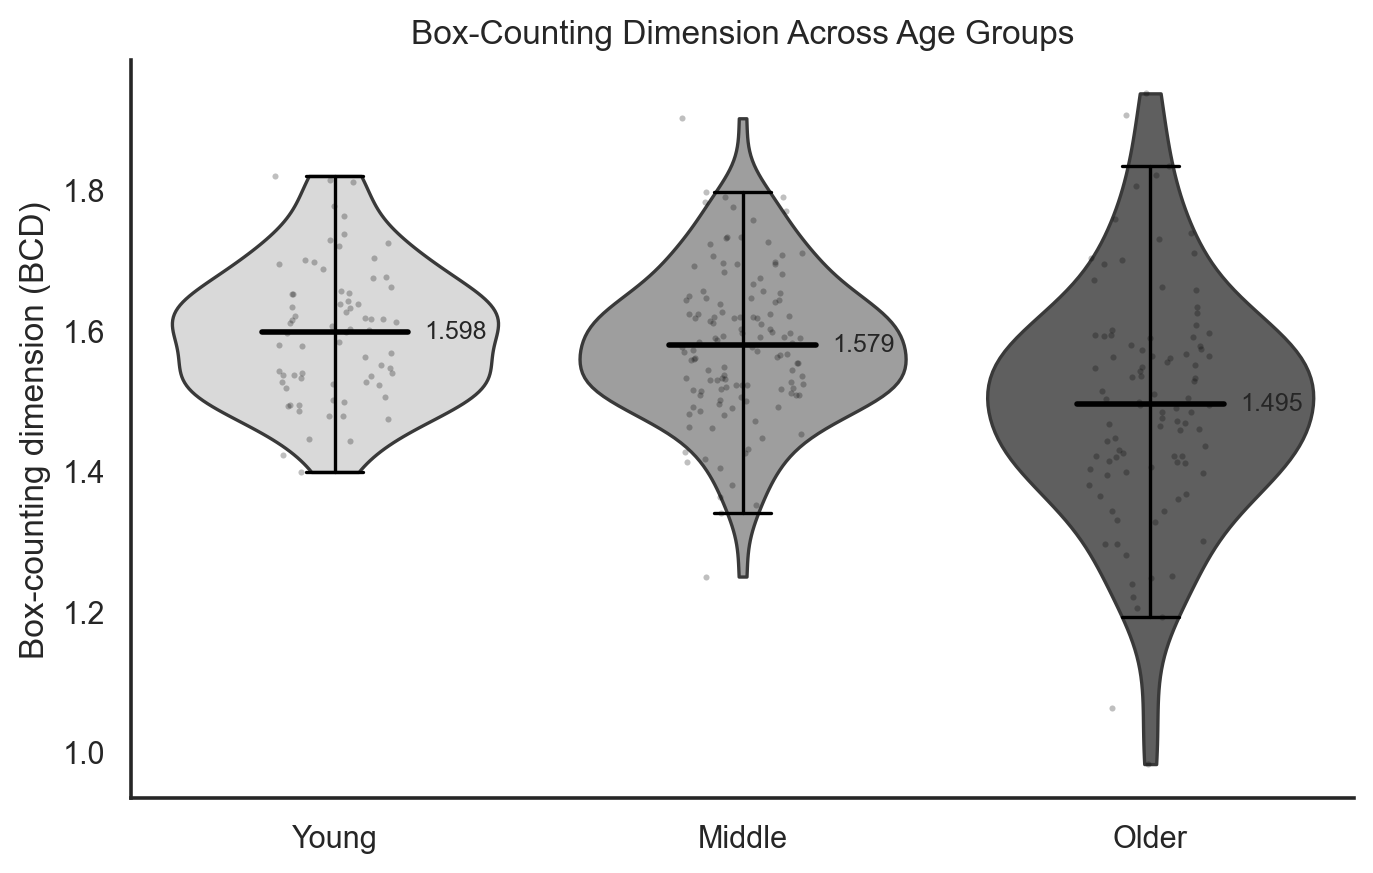

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = bcd_trial_df.copy()

# Etiquetas limpias
group_map = {0: "Young", 1: "Middle", 2: "Older"}
if np.issubdtype(df["group"].dtype, np.number):
    df["group_lbl"] = df["group"].map(group_map)
else:
    df["group_lbl"] = df["group"]

order = ["Young", "Middle", "Older"]
df["group_lbl"] = pd.Categorical(df["group_lbl"], categories=order, ordered=True)

# ---- Estética tipo journal ----
sns.set_theme(style="white")
plt.rcParams.update({
    "figure.dpi": 200,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.3,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "font.size": 11
})

fig, ax = plt.subplots(figsize=(7,4.5))

palette = ["#D9D9D9", "#9E9E9E", "#5F5F5F"]

# --- Violines ---
sns.violinplot(
    data=df,
    x="group_lbl",
    y="BCD",
    order=order,
    cut=0,
    inner=None,
    linewidth=1.2,
    palette=palette,
    ax=ax
)

# --- Whiskers + mean line ---
for i, g in enumerate(order):
    vals = df[df["group_lbl"] == g]["BCD"].values
    
    mean = np.mean(vals)
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    iqr = q3 - q1
    
    lower = vals[vals >= (q1 - 1.5 * iqr)].min()
    upper = vals[vals <= (q3 + 1.5 * iqr)].max()
    
    # Whisker vertical
    ax.plot([i, i], [lower, upper], color="black", linewidth=1.2)
    
    # Caps
    ax.plot([i-0.07, i+0.07], [lower, lower], color="black", linewidth=1.2)
    ax.plot([i-0.07, i+0.07], [upper, upper], color="black", linewidth=1.2)
    
    # --- Mean horizontal line ---
    ax.plot([i-0.18, i+0.18], [mean, mean],
            color="black", linewidth=2)
    
    # --- Mean label ---
    ax.text(i+0.22, mean,
            f"{mean:.3f}",
            va="center",
            fontsize=9)

# --- Raw data suave ---
sns.stripplot(
    data=df,
    x="group_lbl",
    y="BCD",
    order=order,
    color="black",
    alpha=0.25,
    jitter=0.15,
    size=2.2,
    ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("Box-counting dimension (BCD)")
ax.set_title("Box-Counting Dimension Across Age Groups")

sns.despine()
plt.tight_layout()
plt.show()

/var/folders/c_/x_vllk0d7ns2ctmz7dqfpy240000gw/T/ipykernel_74476/878541330.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


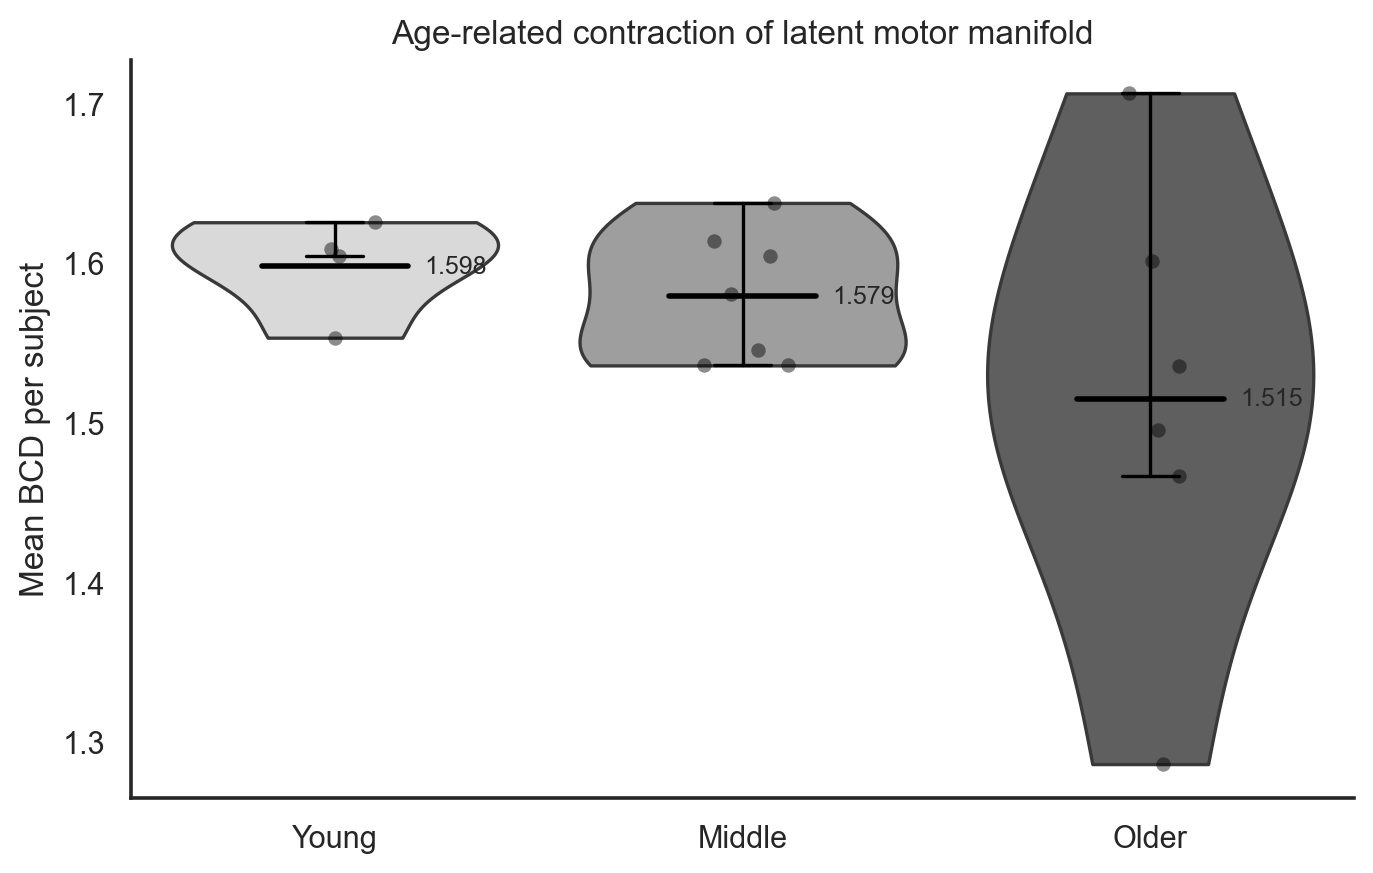

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = bcd_subject_df.copy()

# Etiquetas limpias
group_map = {0: "Young", 1: "Middle", 2: "Older"}
if np.issubdtype(df["group"].dtype, np.number):
    df["group_lbl"] = df["group"].map(group_map)
else:
    df["group_lbl"] = df["group"]

order = ["Young", "Middle", "Older"]
df["group_lbl"] = pd.Categorical(df["group_lbl"], categories=order, ordered=True)

# ---- Estética tipo journal ----
sns.set_theme(style="white")
plt.rcParams.update({
    "figure.dpi": 200,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.3,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "font.size": 11
})

fig, ax = plt.subplots(figsize=(7, 4.5))

# Paleta sobria (puedes dejar todo gris si prefieres)
palette = ["#D9D9D9", "#9E9E9E", "#5F5F5F"]

# --- Violines ---
sns.violinplot(
    data=df,
    x="group_lbl",
    y="BCD_mean",
    order=order,
    cut=0,
    inner=None,          # sin box interno
    linewidth=1.2,
    palette=palette,
    ax=ax
)

# --- Whiskers + mean line + mean label ---
for i, g in enumerate(order):
    vals = df.loc[df["group_lbl"] == g, "BCD_mean"].dropna().values
    if len(vals) == 0:
        continue

    mean = np.mean(vals)
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    iqr = q3 - q1

    # Whiskers tipo Tukey (1.5*IQR) truncados a datos reales
    lower = vals[vals >= (q1 - 1.5 * iqr)].min()
    upper = vals[vals <= (q3 + 1.5 * iqr)].max()

    # Whisker vertical
    ax.plot([i, i], [lower, upper], color="black", linewidth=1.2)

    # Caps
    ax.plot([i - 0.07, i + 0.07], [lower, lower], color="black", linewidth=1.2)
    ax.plot([i - 0.07, i + 0.07], [upper, upper], color="black", linewidth=1.2)

    # Media como línea horizontal
    ax.plot([i - 0.18, i + 0.18], [mean, mean], color="black", linewidth=2.0)

    # Etiqueta de la media
    ax.text(i + 0.22, mean, f"{mean:.3f}", va="center", fontsize=9)

# --- Puntos (sujetos) sobrios ---
sns.stripplot(
    data=df,
    x="group_lbl",
    y="BCD_mean",
    order=order,
    color="black",
    alpha=0.45,
    jitter=0.12,
    size=5.2,
    ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("Mean BCD per subject")
ax.set_title("Age-related contraction of latent motor manifold")

sns.despine()
plt.tight_layout()
plt.show()


## XAI 

In [45]:
#Function to extract latents and features for SHAP 
@torch.no_grad()
def extract_latents(loader, model, pack_batch, subject_mapper,
                    max_steps=None, device=None,
                    return_meta_raw=False, return_features=False):
    """
    Argumento nuevo:
    return_features: Si es True, calcula y retorna estadísticas (mean, max, ptp)
                     del input original.
    """
    model.eval()

    Z_list, yg_list, subj_map_list, log_list = [], [], [], []
    features_list = [] # Nueva lista para estadísticas
    meta_raw_list = []

    for step, batch_items in enumerate(loader, start=1):
        if max_steps is not None and step > max_steps:
            break

        # 1) Parsing de batch
        if isinstance(batch_items, (tuple, list)):
            x, meta0 = batch_items[0], batch_items[1]
        else:
            x, meta0 = batch_items, None

        # 2) Pack para modelo
        batch = pack_batch(x, meta0, subject_mapper)
        x_t = batch["x"]
        if device is not None:
            x_t = x_t.to(device, non_blocking=True)

        # 3) Inferencia (Latentes y Logits)
        out = model(x_t, return_all=True)
        z = out["z"].detach().cpu().numpy()
        logits = out["logits"].detach().cpu().numpy()

        # 4) Cómputo de características estadísticas (Opcional)
        if return_features:
            # Movemos a CPU para procesar con Numpy
            x_cpu = x_t.detach().cpu().numpy() # (Batch, Window, Channels)
            
            f_mean  = np.mean(x_cpu, axis=1)
            f_max   = np.max(x_cpu, axis=1)
            f_range = np.ptp(x_cpu, axis=1) 
            
            # Concatenamos horizontalmente (Batch, 3 * Channels)
            batch_features = np.hstack([f_mean, f_max, f_range])
            features_list.append(batch_features)

        # 5) Metadatos
        yg = batch["y_group"].detach().cpu().numpy().astype(int)
        subj_mapped = batch["patient_id"].detach().cpu().numpy().astype(int)

        Z_list.append(z)
        log_list.append(logits)
        yg_list.append(yg)
        subj_map_list.append(subj_mapped)

        if return_meta_raw and meta0 is not None:
            meta_np = meta0.detach().cpu().numpy() if torch.is_tensor(meta0) else np.asarray(meta0)
            meta_raw_list.append(meta_np[:, :5].astype(int))

    # Concatenación final
    Z = np.concatenate(Z_list, axis=0)
    logits = np.concatenate(log_list, axis=0)
    y_group = np.concatenate(yg_list, axis=0).astype(int)
    subj_mapped = np.concatenate(subj_map_list, axis=0).astype(int)

    results = [Z, y_group, subj_mapped, logits]

    if return_features:
        X_features = np.concatenate(features_list, axis=0)
        results.append(X_features)

    if return_meta_raw:
        meta_raw = np.concatenate(meta_raw_list, axis=0).astype(int)
        results.append(meta_raw)

    return tuple(results)

In [46]:
# Llamada solicitando las características
Z, y_group, subj_id, logits, X_feats = extract_latents(
    test_loader, model, pack_batch, subject_mapper=subject_to_idx,
    device=device, return_features=True
)

print("Latents:", Z.shape)      # (N, latent_dim)
print("Features:", X_feats.shape) # (N, 3 * n_channels)

Latents: (61142, 16)
Features: (61142, 963)


In [47]:
# Create DataFrame for XAI – Feature engineering: Mean and Std for each variable across the 100 time steps
# Load original feature names (321)
# If the file is not available, fall back to generic names
try:
    with open('DataBesa_Variables_names.txt', 'r') as f:
        col_names_original = [line.strip() for line in f.readlines()]
except:
    col_names_original = [f"Var_{i}" for i in range(321)]

# Create extended names (963)
feature_names_stats = []
for suffix in ['_mean', '_max', '_range']:
    for name in col_names_original:
        feature_names_stats.append(f"{name}{suffix}")

# Create DataFrame ready for SHAP
X_df = pd.DataFrame(X_feats, columns=feature_names_stats)
print("XAI DataFrame ready:", X_df.shape)


XAI DataFrame ready: (61142, 963)


In [56]:
gmm_labels= np.load('gmm_labels.npy') 

Training XGBoost to replicate GMM clusters...
Proxy accuracy (should be high > 0.90): 0.9680
Computing SHAP values...


/var/folders/c_/x_vllk0d7ns2ctmz7dqfpy240000gw/T/ipykernel_74476/62706726.py:39: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


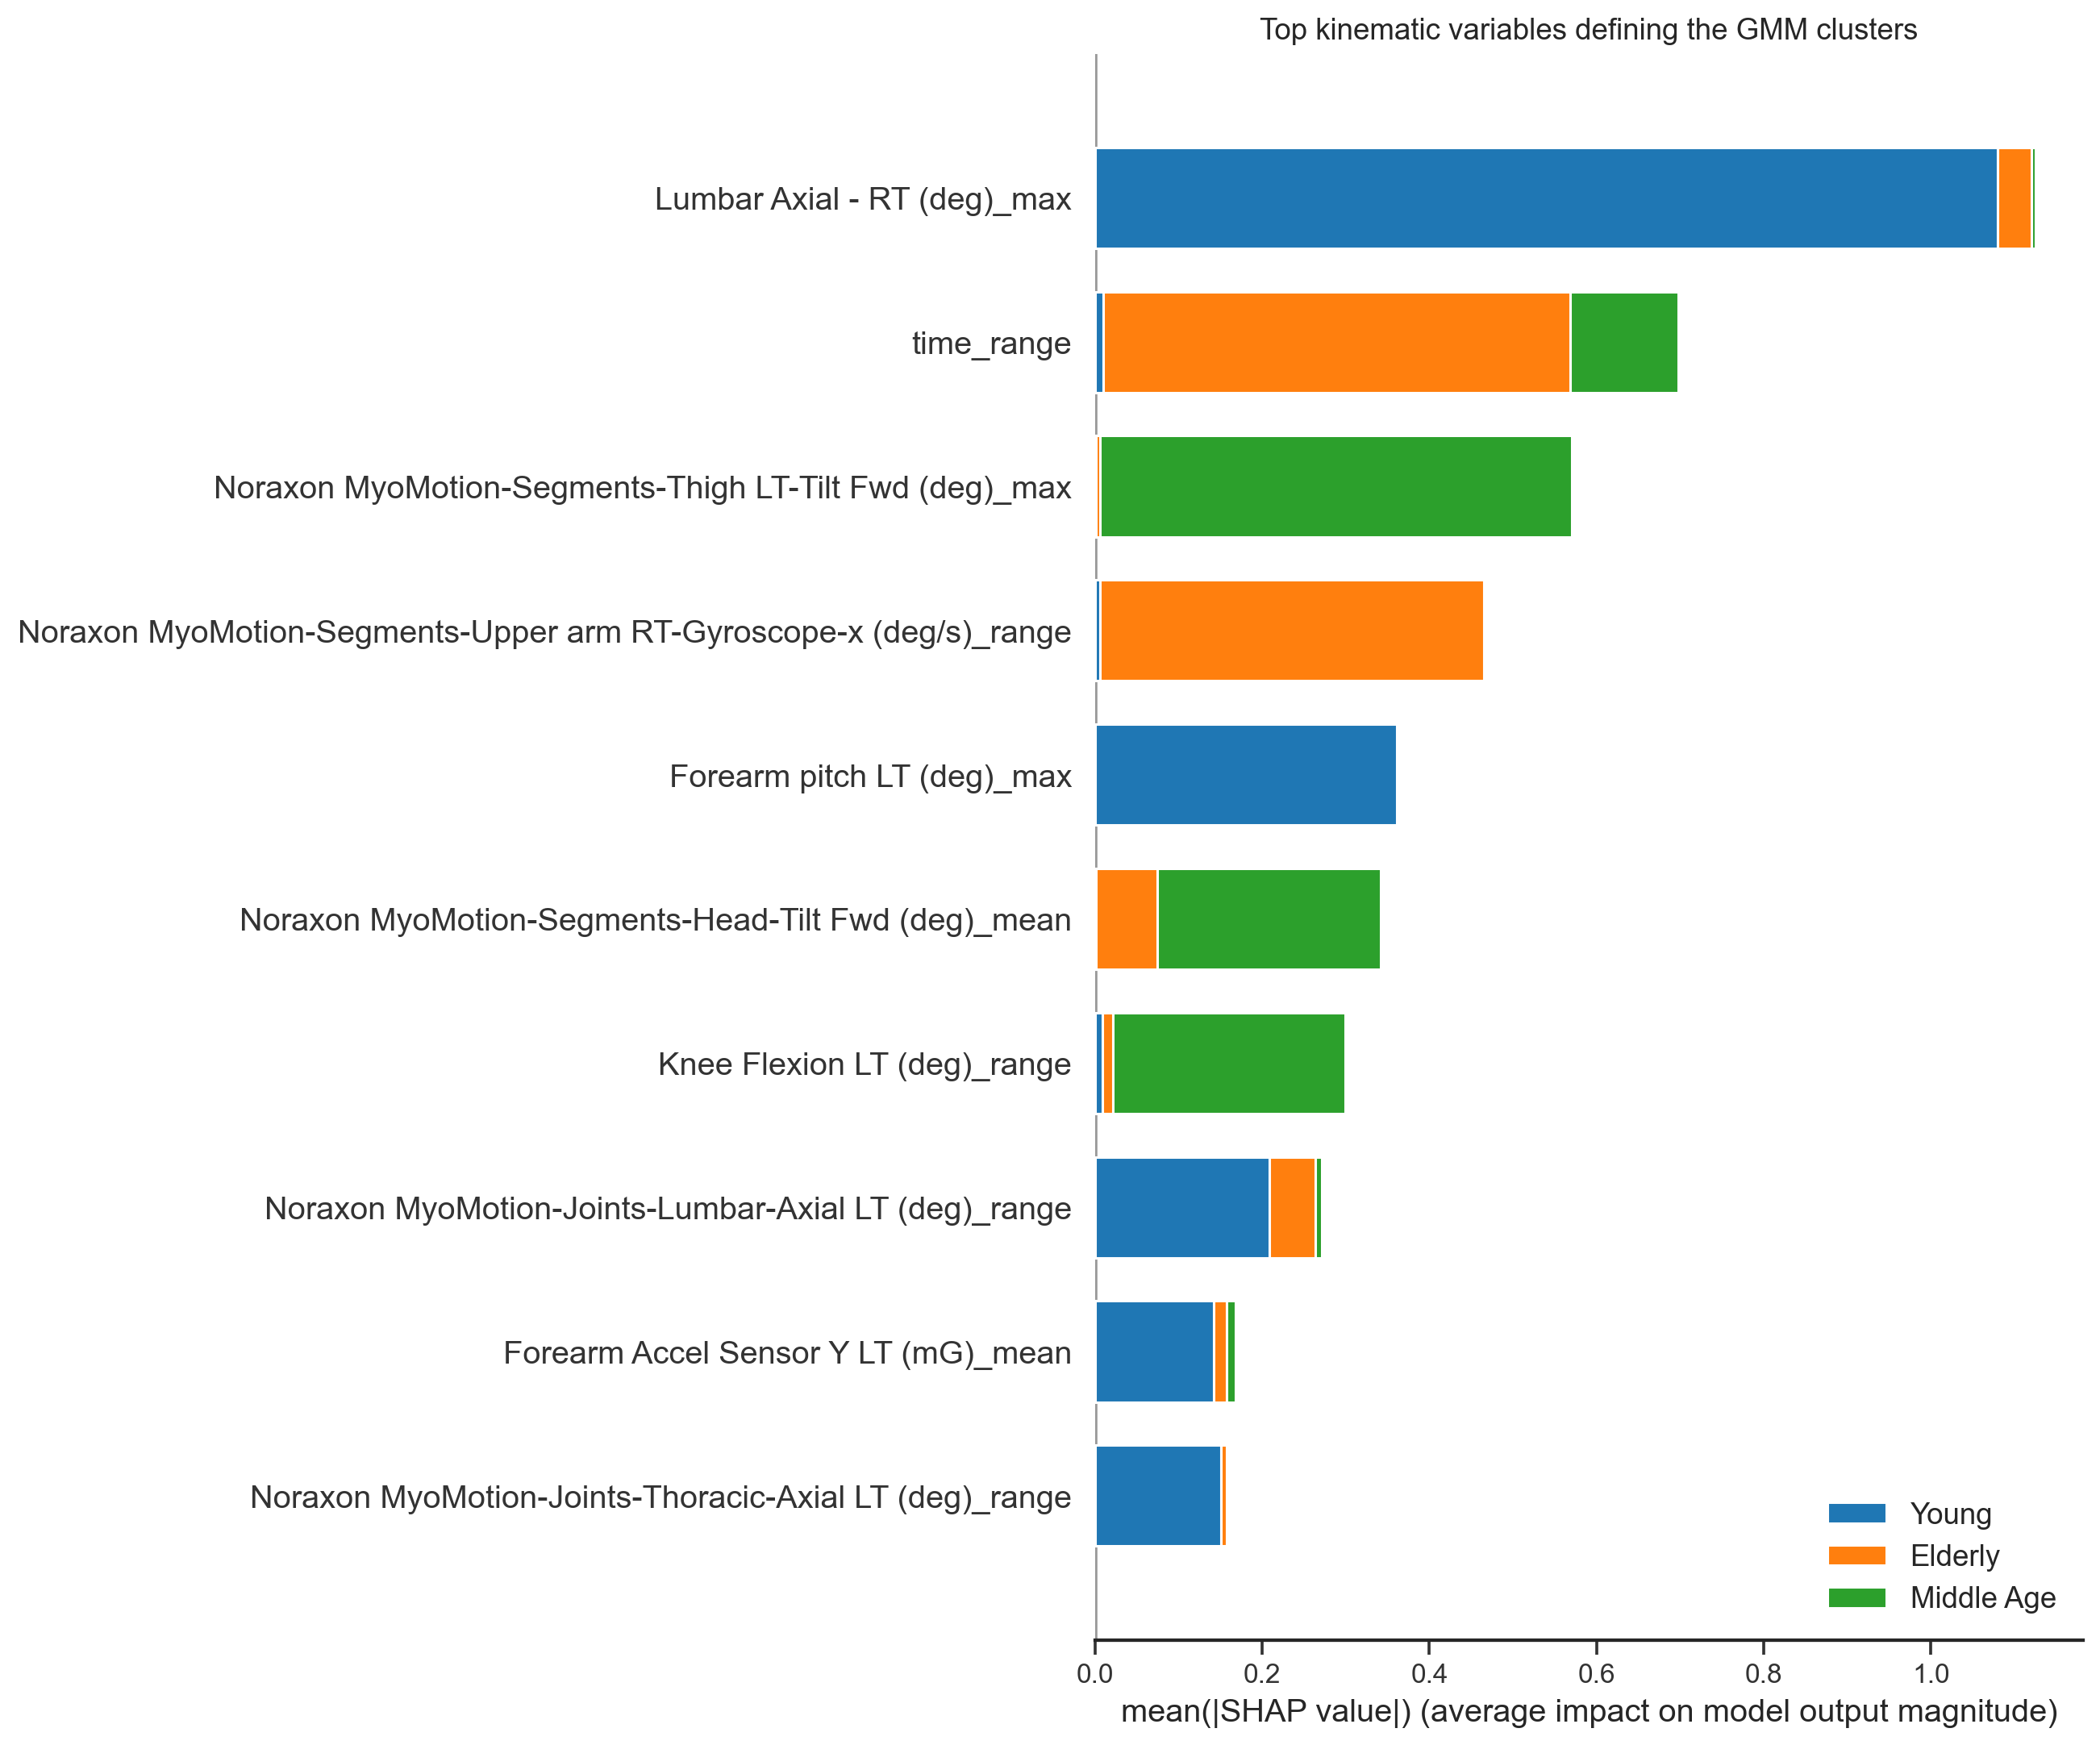

In [58]:
import xgboost as xgb
import shap
from matplotlib.colors import ListedColormap
# Train XGBoost to predict GMM labels from engineered features
# 1. Train Proxy Model
print("Training XGBoost to replicate GMM clusters...")
model_proxy = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    n_jobs=1, # Use 1 core for reproducibility (SHAP can be non-deterministic with n_jobs > 1)
    random_state=SEED,
    subsample=1.0,            
    colsample_bytree=1.0,    
    objective='multi:softprob',
    num_class=3
)

# Train with statistical features and GMM labels
model_proxy.fit(X_df, gmm_labels)

acc = model_proxy.score(X_df, gmm_labels)
print(f"Proxy accuracy (should be high > 0.90): {acc:.4f}")

# 2. Compute SHAP values
# Use a subsample if you have many data points (e.g., 5000) so it doesn’t take too long
print("Computing SHAP values...")
# Take a representative sample to speed up computation
X_sample = X_df.sample(n=min(5000, len(X_df)), random_state=42) 
explainer = shap.TreeExplainer(model_proxy)
shap_values = explainer.shap_values(X_sample)

# 3. Visualize Global Ranking
classes_names = ["Young", "Middle Age", "Elderly"]
mis_colores = ['#1f77b4', '#ff7f0e', '#2ca02c']
cmap_shap = ListedColormap(mis_colores)
plt.figure(figsize=(12, 10))
plt.title("Top kinematic variables defining the GMM clusters")
shap.summary_plot(
    shap_values, 
    X_sample, 
    plot_type="bar", 
    max_display=10,
    show=False,
    class_names=classes_names,
    color=cmap_shap
)

plt.gcf().set_size_inches(12, 10)  
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

In [43]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

def permutation_importance_latents(Z_train, y_train, Z_test, y_test, n_repeats=20, seed=0):
    # Simple linear classifier in latent space
    clf = LogisticRegression(max_iter=2000)
    clf.fit(Z_train, y_train)
    base = balanced_accuracy_score(y_test, clf.predict(Z_test))

    rng = np.random.default_rng(seed)
    drops = np.zeros(Z_train.shape[1], dtype=float)

    for j in range(Z_train.shape[1]):
        scores = []
        for _ in range(n_repeats):
            Zp = Z_test.copy()
            rng.shuffle(Zp[:, j])  # permute column j
            scores.append(balanced_accuracy_score(y_test, clf.predict(Zp)))
        drops[j] = base - np.mean(scores)

    return base, drops  # higher drop => more important

drops=permutation_importance_latents(Z_train, Y_group_train, Z_test, Y_group_test)
print(drops)

(0.6946115863378314, array([ 0.00831793,  0.00083996,  0.03715272,  0.01851297,  0.00429819,
       -0.00282671,  0.0016619 , -0.00848716,  0.01028438,  0.02252491,
        0.00833637,  0.01526245,  0.0044256 , -0.00128337, -0.00306176,
        0.0039636 ]))


# Hurst Exponent 

In [6]:
# test loader for HURST 
test_ds_full = GaitBatchIterable(
    store_path="test_cycles.zarr",
    batch_size=512,          # 
    return_meta=True,
    shuffle=False,            # 
    seed=42,
)

test_loader_full = DataLoader(
    test_ds_full,
    batch_size=None,
    num_workers=0,
    pin_memory=False,
)

In [7]:
# Load the best model
state_dict = torch.load("best_by_utility.pth", map_location=device)
n_subjects=n_subjects_total
n_nuisance=2
model = SemiSupAE(
    steps=100,
    in_dim=336,
    latent=16,
    n_group=3,
    n_subjects=n_subjects,
    n_nuisance=n_nuisance
).to(device)


model.load_state_dict(state_dict)   
model.eval()

SemiSupAE(
  (encoder): BiLSTMEncoder(
    (bilstm): LSTM(336, 128, batch_first=True, bidirectional=True)
    (to_latent): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): LSTMDecoder(
    (init): Linear(in_features=16, out_features=128, bias=True)
    (lstm): LSTM(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=336, bias=True)
  )
  (group_head): HeadMLP(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (proj_head): ProjectionHead(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (grl): GRL()
  (nuis_head): HeadMLP(
    (net): Sequential(
      (0): Lin

In [8]:
# Load trial_day_slides 
import json
from pathlib import Path
import numpy as np

def load_trial_day_slices(trial_day_slices_json):
    """
    Expected:
      { "sid": { "trial": { "day": [lo, hi], ... }, ... }, ... }
    Returns interval index for fast mapping by cycle_id.
    """
    obj = json.loads(Path(trial_day_slices_json).read_text())
    intervals = []  # (lo, hi, sid, day, trial)
    for sid_str, tr_dict in obj.items():
        sid = int(sid_str)
        for tr_str, day_dict in tr_dict.items():
            tr = int(tr_str)
            for day_str, v in day_dict.items():
                day = int(day_str)
                lo, hi = int(v[0]), int(v[1])
                if hi > lo:
                    intervals.append((lo, hi, sid, day, tr))

    intervals.sort(key=lambda x: x[0])
    los = np.array([x[0] for x in intervals], dtype=np.int64)
    his = np.array([x[1] for x in intervals], dtype=np.int64)
    sids = np.array([x[2] for x in intervals], dtype=np.int64)
    days = np.array([x[3] for x in intervals], dtype=np.int64)
    trs  = np.array([x[4] for x in intervals], dtype=np.int64)
    return (los, his, sids, days, trs)

def map_cycle_ids_to_trial_day(cycle_ids, interval_index):
    """
    cycle_ids: (N,)
    interval_index: (los, his, sids, days, trs)
    Returns:
      sid_raw (N,), day_raw (N,), tr_raw (N,), cidx (N,), ok (N,)
    """
    los, his, sids, days, trs = interval_index
    x = np.asarray(cycle_ids, dtype=np.int64)

    j = np.searchsorted(los, x, side="right") - 1
    ok = (j >= 0) & (x < his[j])

    sid_raw = np.full_like(x, -1)
    day_raw = np.full_like(x, -1)
    tr_raw  = np.full_like(x, -1)
    cidx    = np.full_like(x, -1)

    sid_raw[ok] = sids[j[ok]]
    day_raw[ok] = days[j[ok]]
    tr_raw[ok]  = trs[j[ok]]
    cidx[ok]    = x[ok] - los[j[ok]]
    return sid_raw, day_raw, tr_raw, cidx, ok

In [9]:
# Check metadata mapping
meta_np = meta0.detach().cpu().numpy()
cycle_id_np = cycle_id.detach().cpu().numpy()

print("meta_np shape:", meta_np.shape)
print("meta columns example rows (first 5):")
print(meta_np[:5])

# col meanings (provisional)
colnames = ["sid","group","day","session","trial","direction","cycle_in_trial"]
for j, name in enumerate(colnames):
    u = np.unique(meta_np[:, j])
    print(f"\n{name} (col {j}) unique count={len(u)} sample={u[:20]}")
    print(f"min/max: {u.min()} / {u.max()}")

meta_np shape: (72, 7)
meta columns example rows (first 5):
[[  4.   1.   1.   3.   3.   1. 108.]
 [  5.   1.   1.   2.   3.   1. 201.]
 [ 28.   1.   2.   3.   1.   0. 185.]
 [ 47.   2.   1.   1.   3.   0. 122.]
 [ 43.   2.   1.   3.   3.   0.  39.]]

sid (col 0) unique count=9 sample=[ 0.  4.  5.  9. 19. 26. 28. 43. 47.]
min/max: 0.0 / 47.0

group (col 1) unique count=4 sample=[0. 1. 2. 3.]
min/max: 0.0 / 3.0

day (col 2) unique count=3 sample=[0. 1. 2.]
min/max: 0.0 / 2.0

session (col 3) unique count=4 sample=[0. 1. 2. 3.]
min/max: 0.0 / 3.0

trial (col 4) unique count=4 sample=[0. 1. 2. 3.]
min/max: 0.0 / 3.0

direction (col 5) unique count=2 sample=[0. 1.]
min/max: 0.0 / 1.0

cycle_in_trial (col 6) unique count=56 sample=[ 0.  2.  3.  6. 10. 12. 14. 17. 22. 24. 26. 29. 31. 33. 39. 41. 42. 46.
 58. 61.]
min/max: 0.0 / 214.0


In [51]:
meta_np = meta0.numpy()
cycle_id_np = cycle_id.numpy() if torch.is_tensor(cycle_id) else np.asarray(cycle_id)
def build_trial_id(meta_np):
    sid = meta_np[:,0].astype(int)
    grp = meta_np[:,1].astype(int)
    day = meta_np[:,2].astype(int)
    ses = meta_np[:,3].astype(int)
    tr  = meta_np[:,4].astype(int)
    return np.array(
        [f"S{s:03d}_G{g:02d}_D{d:02d}_B{b:02d}_T{t:02d}"
         for s,g,d,b,t in zip(sid,grp,day,ses,tr)],
        dtype=object
    )

trial_id = build_trial_id(meta_np)
cycle_in_trial = meta_np[:, -1].astype(int)  # última columna

df_chk = pd.DataFrame({
    "trial_id": trial_id,
    "cycle_in_trial": cycle_in_trial,
    "cycle_id": cycle_id.astype(int),
})

# Elige 3 trials al azar (reproducible)
rng = np.random.default_rng(0)
some_trials = rng.choice(df_chk["trial_id"].unique(), size=min(3, df_chk["trial_id"].nunique()), replace=False)

for tid in some_trials:
    g = df_chk[df_chk["trial_id"] == tid].copy()
    g = g.sort_values("cycle_in_trial")
    print("\nTRIAL:", tid, "n=", len(g))
    print("cycle_in_trial min/max:", g["cycle_in_trial"].min(), g["cycle_in_trial"].max())
    print("duplicates in cycle_in_trial:", g["cycle_in_trial"].duplicated().sum())
    # mira primeros/últimos 10
    print("head cycle_in_trial:", g["cycle_in_trial"].head(10).to_list())
    print("tail cycle_in_trial:", g["cycle_in_trial"].tail(10).to_list())

ValueError: All arrays must be of the same length

In [ ]:
# new extract latents with cycle_id + trial mapping
@torch.no_grad()
def extract_latentsH(
    loader, model, pack_batch, subject_mapper,
    max_steps=None, device=None,
    return_meta_raw=False,
    return_cycle_id=False,
    trial_day_slices_json=None,
    return_trial_fields=False,
):
    model.eval()

    interval_index = None
    if (trial_day_slices_json is not None) and return_trial_fields:
        interval_index = load_trial_day_slices(trial_day_slices_json)

    Z_list, yg_list, subj_map_list, log_list = [], [], [], []
    meta_raw_list = []
    cycle_id_list = []

    for step, batch_items in enumerate(loader, start=1):
        if max_steps is not None and step > max_steps:
            break

        # Expect (x, meta0, cycle_id) from your full loader
        x, meta0, cycle_id = batch_items

        batch = pack_batch(x, meta0, subject_mapper)

        x_t = batch["x"]
        if device is not None:
            x_t = x_t.to(device, non_blocking=True)

        out = model(x_t, return_all=True)
        z = out["z"].detach().cpu().numpy()
        logits = out["logits"].detach().cpu().numpy()

        yg = batch["y_group"].detach().cpu().numpy().astype(int)
        subj_mapped = batch["patient_id"].detach().cpu().numpy().astype(int)

        Z_list.append(z)
        log_list.append(logits)
        yg_list.append(yg)
        subj_map_list.append(subj_mapped)

        if return_meta_raw:
            meta_np = meta0.detach().cpu().numpy() if hasattr(meta0, "detach") else np.asarray(meta0)
            meta_raw_list.append(meta_np[:, :5].astype(int))

        if return_cycle_id:
            cid_np = cycle_id.detach().cpu().numpy().astype(np.int64) if hasattr(cycle_id, "detach") else np.asarray(cycle_id, dtype=np.int64)
            cycle_id_list.append(cid_np)

    Z = np.concatenate(Z_list, axis=0)
    logits = np.concatenate(log_list, axis=0)
    y_group = np.concatenate(yg_list, axis=0).astype(int)
    subj_mapped = np.concatenate(subj_map_list, axis=0).astype(int)

    outputs = [Z, y_group, subj_mapped, logits]

    meta_raw = None
    if return_meta_raw:
        meta_raw = np.concatenate(meta_raw_list, axis=0).astype(int)
        outputs.append(meta_raw)

    cycle_id_all = None
    if return_cycle_id:
        cycle_id_all = np.concatenate(cycle_id_list, axis=0).astype(np.int64)
        outputs.append(cycle_id_all)

    # --- New: trial_id + cidx_trial from trial_day_slices ---
    if return_trial_fields:
        if interval_index is None or cycle_id_all is None:
            raise ValueError("return_trial_fields=True requires trial_day_slices_json and return_cycle_id=True")

        sid2, day2, tr2, cidx_trial, ok = map_cycle_ids_to_trial_day(cycle_id_all, interval_index)
        if not np.all(ok):
            raise RuntimeError(f"{int((~ok).sum())} cycle_ids did not map to any interval in trial_day_slices_json")

        # Build stable id: include day+trial; optionally block if you want from meta_raw
        trial_id = np.array(    [f"S{s:03d}_D{d:02d}_B{b:02d}_T{t:02d}" for s,d,b,t in zip(sid,day,blk,tr)],
    dtype=object
)

        outputs.extend([trial_id, cidx_trial, sid2, day2, tr2])

    return tuple(outputs)

In [ ]:
# 
import numpy as np
import pandas as pd

LATENT_COLS = [f"z{i}" for i in range(16)]

def build_trial_id_from_meta(meta_raw):
    # meta_raw: [sid, group, day, block/session, trial]
    sid   = meta_raw[:,0].astype(int)
    grp   = meta_raw[:,1].astype(int)
    day   = meta_raw[:,2].astype(int)
    blk   = meta_raw[:,3].astype(int)
    tr    = meta_raw[:,4].astype(int)

    trial_id = np.array(
        [f"S{s:03d}_G{g:02d}_D{d:02d}_B{b:02d}_T{t:02d}" for s,g,d,b,t in zip(sid,grp,day,blk,tr)],
        dtype=object
    )
    return trial_id

def compute_H_latent_per_trial(Z, meta_raw, cycle_id, bayesH_samples, n_iter=2000, seed=42):
    """
    Z: (N,16) latents per cycle
    meta_raw: (N,5) [sid,group,day,block,trial]
    cycle_id: (N,) global cycle idx
    bayesH_samples: callable(x_1d, n_iter, seed)-> 1D array of samples

    Returns df_Hlatent:
      trial_id, n_cycles, H_z0_med, H_z0_ci_lo, H_z0_ci_hi, ..., H_z15_*
    """
    trial_id = build_trial_id_from_meta(meta_raw)

    df = pd.DataFrame(Z, columns=LATENT_COLS)
    df["trial_id"] = trial_id
    df["cycle_id"] = cycle_id.astype(np.int64)

    # orden temporal dentro del trial
    df = df.sort_values(["trial_id", "cycle_id"], kind="mergesort")

    rows = []
    for tid, g in df.groupby("trial_id", sort=False):
        row = {"trial_id": tid, "n_cycles": int(len(g))}

        for k in range(16):
            x = g[f"z{k}"].to_numpy(dtype=float)

            # HKp posterior samples
            samples = np.asarray(bayesH_samples(x, n_iter=n_iter, seed=seed), dtype=float)

            row[f"H_z{k}_med"] = float(np.median(samples))
            row[f"H_z{k}_ci_lo"] = float(np.percentile(samples, 2.5))
            row[f"H_z{k}_ci_hi"] = float(np.percentile(samples, 97.5))

        rows.append(row)

    return pd.DataFrame(rows)

In [ ]:
# Extract latents + meta + trial mapping    
Zt, yt, subjt, logitst, meta_raw, cycle_id, trial_id, cidx_trial, sid2, day2, tr2 = extract_latentsH(
    test_loader_full,
    model,
    pack_batch,
    subject_to_idx,
    return_meta_raw=True,
    return_cycle_id=True,
    trial_day_slices_json="test_trial_day_slices.json",
    return_trial_fields=True,
    device=device,
)
import pandas as pd


df_cycles = build_cycle_df(Zt, meta_raw, cycle_id)
df_trial_features = latent_trial_features(df_cycles)




In [ ]:
# Load Hurst exponents per trial
H_PATH = "Trials_Spatiotemporal_NONAN_metrics.csv"

hurst_cols = [
    "hurst_right_stride_length",
    "hurst_right_stride_interval",
    "hurst_rom_right_hip",
    "hurst_rom_right_knee",
    "hurst_rom_right_ankle",
]

H_df = pd.read_csv(H_PATH)

# --- Parse meta strings -> ints ---
# id: "S002" -> 2
H_df["sid"] = H_df["id"].astype(str).str.extract(r"S(\d+)", expand=False).astype(float).astype("Int64")

# group: "G01" -> 1
H_df["group"] = H_df["group"].astype(str).str.extract(r"G(\d+)", expand=False).astype(float).astype("Int64")

# day/block/trial: "D02","B03","T01" -> 2,3,1
H_df["day"]   = H_df["day"].astype(str).str.extract(r"D(\d+)", expand=False).astype(float).astype("Int64")
H_df["block"] = H_df["block"].astype(str).str.extract(r"B(\d+)", expand=False).astype(float).astype("Int64")
H_df["trial"] = H_df["trial"].astype(str).str.extract(r"T(\d+)", expand=False).astype(float).astype("Int64")

# --- Drop rows without complete meta or without hurst values ---
H_df = H_df.dropna(subset=["sid","group","day","block","trial"] + hurst_cols).copy()

# --- Build trial_id (MUST match df_trial_features) ---
H_df["trial_id"] = H_df.apply(
    lambda r: f"S{int(r.sid):03d}_G{int(r.group):02d}_D{int(r.day):02d}_B{int(r.block):02d}_T{int(r.trial):02d}",
    axis=1
)

# Keep only needed columns
H_df = H_df[["trial_id","sid","group","day","block","trial"] + hurst_cols].copy()

# If there are accidental duplicates per trial_id, collapse safely
H_df = H_df.groupby("trial_id", as_index=False).agg(
    sid=("sid","first"),
    group=("group","first"),
    day=("day","first"),
    block=("block","first"),
    trial=("trial","first"),
    **{c: (c, "mean") for c in hurst_cols}
)

In [ ]:
# Function bayesH_py 
import bayesH_py
samples = bayesH_py.bayesH_samples(np.random.randn(200), n_iter=2000, seed=42)
print(np.median(samples))

In [ ]:
# df_trial_features debe tener trial_id + z*_... features.
df_merged = df_trial_features.merge(H_df, on="trial_id", how="inner")

# Usar SOLO features del latent (evita fuga / confusión con meta)
z_cols = [c for c in df_trial_features.columns if c.startswith("z")]

# (opcional) sanity check: asegúrate que no entran meta cols
print("N merged trials:", len(df_merged))
print("Num z-features:", len(z_cols))
print("ejemplo z cols:", z_cols[:10])